# Module Imports

In [392]:
import itertools
import json
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mne
import neurokit2 as nk
import nibabel as nb
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

from cca_zoo.models import MCCA
from dcor import distance_correlation, rowwise
from matplotlib import cm, gridspec, colors
from matplotlib.ticker import MaxNLocator
from matplotlib.lines import Line2D
from matplotlib.patches import ConnectionPatch
from mne.time_frequency import tfr_array_morlet, tfr_multitaper, tfr_morlet
from utils.glm_utils import linear_regression, get_hrf, convolve_hrf, onsets_to_block, xcorr
from utils.notebook_utils import commonality_analysis, evaluate_model, lag_basis, \
load_pca_results, load_subj_chang, load_subj_chang_bh, load_subj_hcp, load_subj_nki, load_subj_yale, \
load_subj_spreng, timeseries_cv, fs_chang, fs_hcp, fs_nki, fs_spreng, fs_yale, xcorr_select_max
from utils.signal.butterworth_filters import butterworth_filter
from utils.stationary_block_bootstrap import resample as ts_resample
from utils.load_write import convert_2d, load_data, load_nki_event_file, write_nifti
from run_taskbh_chang_analysis import construct_deep_breath_blocks, load_chang_bh_event_file
from run_taskbh_nki_analysis import construct_task_blocks
from patsy import dmatrix
from scipy.io import loadmat
from scipy.signal import hilbert, welch, csd, find_peaks
from scipy.interpolate import interp1d
from scipy.stats import zscore, gaussian_kde, circmean, circstd
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import TimeSeriesSplit


# 1. Load Subject List and PCA Time Courses

## 1.1 Subject Lists

In [166]:
subject_list_hcp = pd.read_csv('data/dataset_hcp/subject_list_hcp.csv')
subject_list_chang = pd.read_csv('data/dataset_chang/subject_list_chang.csv')
subject_list_nki = pd.read_csv('data/dataset_nki/subject_list_nki.csv')
subject_list_chang_bh = pd.read_csv('data/dataset_chang_bh/subject_list_chang_bh.csv')
subject_list_spreng = pd.read_csv('data/dataset_spreng/subject_list_spreng.csv')
subject_list_yale = pd.read_csv('data/dataset_yale/subject_list_yale.csv')

# subject list dictionary
subj_dict = {
    'chang': subject_list_chang,
    'chang_bh': subject_list_chang_bh,
    'nki': subject_list_nki,
    'hcp': subject_list_hcp,
    'spreng': subject_list_spreng,
    'yale': subject_list_yale
}

## 1.2. Load PCA Time Courses and Set Global Variables

In [176]:
chang_pca_fps = ['results/pca/chang_pca_group_results.pkl', 'results/pca/chang_pca_group_promax_results.pkl']
chang_len = 693
pc_subj_chang, pc_p_subj_chang, _ = load_pca_results(subject_list_chang, chang_pca_fps[0], chang_pca_fps[1], 
                                                     chang_len, scan_ind=True)

chang_bh_pca_fps = ['results/pca/chang_bh_pca_group_results.pkl', 
                    'results/pca/chang_bh_pca_group_promax_results.pkl',
                    'results/cpca/chang_bh_pca_group_c_results.pkl']
pc_subj_chang_bh, pc_p_subj_chang_bh, pc_c_subj_chang_bh = \
load_pca_results(subject_list_chang_bh, chang_bh_pca_fps[0], chang_bh_pca_fps[1],
                 n_len=None, pca_c_fp=chang_bh_pca_fps[2], scan_ind=True, scan_len=subject_list_chang_bh.nframes)

hcp_pca_fps = ['results/pca/hcp_fix_pca_group_results.pkl', 'results/pca/hcp_fix_pca_group_promax_results.pkl']
hcp_len = 1200
pc_subj_hcp, pc_p_subj_hcp, _ = load_pca_results(subject_list_hcp, hcp_pca_fps[0], hcp_pca_fps[1], hcp_len)

nki_pca_fps = ['results/pca/nki_pca_group_results.pkl', 'results/pca/nki_pca_group_promax_n3_results.pkl']
nki_len = 186
pc_subj_nki, pc_p_subj_nki, _ = load_pca_results(subject_list_nki, nki_pca_fps[0], nki_pca_fps[1], nki_len)

spreng_pca_fps = ['results/pca/spreng_pca_group_results.pkl', 'results/pca/spreng_pca_group_promax_results.pkl']
spreng_len = 200
pc_subj_spreng, pc_p_subj_spreng, _ = load_pca_results(subject_list_spreng, spreng_pca_fps[0], 
                                                       spreng_pca_fps[1], spreng_len)

yale_pca_fps = ['results/pca/yale_pca_group_results.pkl', 'results/pca/yale_pca_group_promax_results.pkl']
yale_len = 400
pc_subj_yale, pc_p_subj_yale, _ = load_pca_results(subject_list_yale, yale_pca_fps[0], 
                                                   yale_pca_fps[1], yale_len, scan_ind=True)

pca_dict = {
    'chang': [pc_subj_chang, pc_p_subj_chang],
    'chang_bh': [pc_subj_chang_bh, pc_p_subj_chang_bh],
    'nki': [pc_subj_nki, pc_p_subj_nki],
    'hcp': [pc_subj_hcp, pc_p_subj_hcp],
    'spreng': [pc_subj_spreng, pc_p_subj_spreng],
    'yale': [pc_subj_yale, pc_p_subj_yale]
}

# Scan length dictionary (chang_bh dataset has varying scan length)
len_dict = {
    'chang': chang_len,
    'hcp': hcp_len,
    'nki': nki_len,
    'spreng': spreng_len,
    'yale': yale_len
}

# sampling frequency dictionary
sf_dict = {
    'chang': fs_chang,
    'chang_bh': fs_chang,
    'hcp': fs_hcp,
    'nki': fs_nki,
    'spreng': fs_spreng,
    'yale': fs_yale
}

# Label dictionary (as labeled in the manuscript)
label_dict = {
    'chang': 'ME-REST',
    'chang_bh': 'ME-TASK',
    'hcp': 'HCP-REST',
    'nki': 'NKI-TASK',
    'spreng': 'ME-REST-SUPP',
    'yale': 'YALE-REST'
}

# Data Loader dictionary
data_load_dict = {
    'chang': load_subj_chang,
    'chang_bh': load_subj_chang_bh,
    'hcp': load_subj_hcp,
    'nki': load_subj_nki,
    'spreng': load_subj_spreng,
    'yale': load_subj_yale
}

# Physio variable to label dictionary
physio_label_dict = {
    'PPG_HR_NK': 'HR',
    'PPG_LOW_NK': 'PPG Low-Freq',
    'PPG_PEAK_AMP': 'PPG Peak Amplitude',
    'RESP_RVT_NK': 'Resp Volume',
    'GSR': 'Skin Conductance',
    'pupil': 'Pupil Diameter',
    'pc1': 'PC1',
    'csf': 'CSF',
    'Alpha': 'Alpha EEG'
}

# 2. Pattern One and Electrophysiological Cross-Correlations

## 2.1 Cross-Correlations

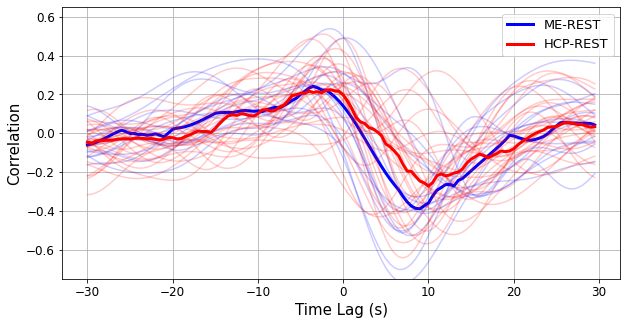

In [95]:
## Choose:
# Electrophysio Signals: PPG_LOW_NK, RESP_RVT_NK, PPG_HR_NK, PPG_PEAK_AMP, Alpha, Infraslow, csf, pupil
e_signal = 'RESP_RVT_NK'

# dataset = ['chang', 'hcp', 'spreng', 'yale']
datasets = ['chang', 'hcp']

# select time series similarity function ('correlation' or 'mutual_information')
corr_func = 'correlation'

# set permutation parameters
permute=False
n_perm=100
## 

fig, ax = plt.subplots(1,1, figsize=(10,5))

# Inperpolation parameters
x_interp = np.arange(-30, 30, 0.5)

# Color dictionary
color_dict = {
    'chang': 'blue',
    'hcp': 'red',
    'spreng': 'green',
    'yale': 'darkorange'
}


# Cross-correlation max lag dict
cc_len_dict = {
    'chang': 20,
    'hcp': 60,
    'spreng': 16,
    'yale': 30
}

# Create permutations
if permute:
    perm_vec =  {d: np.random.randint(-len_dict[d],len_dict[d], n_perm) for d in datasets}
    permute_cc = {d: [] for d in datasets}
    
# create time series similarity function
if corr_func == 'correlation':
    def ts_sim(x,y,maxlag):
        return xcorr(x, y, maxlags=maxlag)
elif corr_func == 'distance_correlation':
    def ts_sim(x,y, maxlag):
        lag_array = np.arange(-maxlag,maxlag+1)[::-1]
        x_shift = [np.roll(x, i) for i in lag_array]
        y_copy = [y for i in lag_array]
        cc = rowwise(distance_correlation, x_shift, y_copy)
        return lag_array[::-1], cc
    
# Loop through datasets and calculate cross-correlations
for d in datasets:
    interp_cc = []
    subj_list = subj_dict[d]
    data_load = data_load_dict[d]
    for i in range(subj_list.shape[0]):
        # Load Subject
        if d in ['chang','yale']:
            if d == 'chang':
                subj, scan = int(subj_list.iloc[i]['subject']), int(subj_list.iloc[i]['scan'])
            elif d == 'yale':
                subj, scan = subj_list.iloc[i]['subject'], int(subj_list.iloc[i]['scan'])
            df = data_load(subj, scan, pca_dict[d][0][f'{subj}_{scan}'], 
                           pca_dict[d][1][f'{subj}_{scan}'], sf_dict[d])
        else:
            subj = subj_list.iloc[i]['subject']
            df = data_load(subj, pca_dict[d][0][f'{subj}'], 
                           pca_dict[d][1][f'{subj}'], sf_dict[d])
        # Compute cross-correlation
        cc_list = ts_sim(df['pc1'].values, df[e_signal].values, cc_len_dict[d])
        f_interp = interp1d(cc_list[0]*(1/sf_dict[d]), cc_list[1], kind='cubic')
        interp_cc.append(f_interp(x_interp))
        # Create permutation distribution, if specified
        if permute:
            permute_subj_cc = []
            for p in perm_vec[d]:
                # Supress divide by invalid value warning
                with warnings.catch_warnings():
                    warnings.filterwarnings("ignore", message="invalid value encountered in true_divide")
                    surrogate = nk.signal_surrogate(df[e_signal].values, method='IAAFT', 
                                                    max_iter=100, atol=1e-5, rtol=1e-6)
                _, cc = ts_sim(df['pc1'].values, surrogate, cc_len_dict[d])
                permute_subj_cc.append(cc)
            permute_cc[d].append(np.vstack(permute_subj_cc))
    
    ax.plot(x_interp, np.median(interp_cc, axis=0), linewidth=3, color=color_dict[d], label=label_dict[d])
    ax.plot(x_interp, np.array(interp_cc).T, color=color_dict[d], alpha=0.2)

ax.grid(True)
ax.legend(fontsize=13)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xlabel('Time Lag (s)', fontsize=15)
if corr_func == 'correlation':
    ax.set_ylim([-0.75, 0.65])
    ax.set_ylabel('Correlation', fontsize=15)
elif corr_func == 'distance_correlation':
    ax.set_ylim([0, 0.65])
    ax.set_ylabel('Distance Correlation', fontsize=15)

if permute:
    for d in datasets:
        perm_concat = np.stack(permute_cc[d], axis=2)
        perm_avg = np.abs(np.mean(perm_concat, axis=2))
        p_05 = np.quantile(perm_avg, 0.95)
        if corr_func == 'correlation':
            ax.axhline(p_05, 0, 1, color=color_dict[d], alpha=0.5, linestyle = '--')
            ax.axhline(-p_05, 0, 1, color=color_dict[d], alpha=0.5, linestyle = '--')
        elif corr_func == 'distance_correlation':
            ax.axhline(p_05, 0, 1, color=color_dict[d], alpha=0.7, linestyle = '--')


## 2.2 EEG Power Cross-Correlations

In [ ]:
# Select frequencies
freqs = np.linspace(2,20, 30)[::-1]
# Select EEG channels 
eeg_chan_avg = ['P3', 'P4', 'Pz', 'O1','O2','Oz']
# Loop through subjects and compute cross-correlations
power_group = []
for subj, scan in subject_list_chang[['subject','scan']].values.tolist():
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
    raw = mne.io.read_raw_fif(f'data/dataset_chang/eeg/raw/sub_00{subj}_mr_{scan_str}.raw.fif', preload=True, 
                              verbose=False)
    raw.crop(tmin=14.7) # crop 14.7s to match functional scan
    raw.pick(eeg_chan_avg) # Pick EEG channels
    # set n_cycle parameter for wavelet (> cycles, > frequency resolution & < time resolution)
    n_cycles = 15
    # Commented out multitaper power estimation approach
    # time_bandwidth = 4.0  
    # power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
    #                        time_bandwidth=time_bandwidth, return_itc=False, 
    #                        average=True)
    # Grab parameters
    times = raw.times
    sfreq = raw.info['sfreq']
    # Get data into numpy array
    raw_data = raw.get_data()[np.newaxis,:]
    # Morlet time-frequency power estimation
    power = tfr_array_morlet(raw_data, sfreq, freqs, n_cycles=n_cycles, output='power')
    power_avg = np.squeeze(power).mean(axis=0)
    power_group.append(power_avg)

# Resample data to match functional scan length
power_resample = []
for subj_power in power_group:
    power_freq = []
    for i in range(len(freqs)):
        resample_freq = nk.signal_resample(subj_power[i,:], desired_length=chang_len, method='FFT')
        power_freq.append(resample_freq)
    power_freq = np.vstack(power_freq)
    power_resample.append(power_freq)

# Cross-correlation across subjects and frequencies
xcorr_results = []
# interpolation time points for smooth cross-corr estimation
x_interp = np.arange(-30, 30, 0.5)
for i, (subj, scan) in enumerate(subject_list_chang[['subject','scan']].values.tolist()):
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    xcorr_subj = []
    # Loop through frequencies
    for f in range(len(freqs)):
        cc_list = xcorr(df['pc1'], power_resample[i][f,:], maxlags=20)
        f_interp = interp1d(cc_list[0]*(1/fs_chang), cc_list[1], kind='cubic')
        xcorr_subj.append(f_interp(x_interp))
    xcorr_subj = np.vstack(xcorr_subj)
    xcorr_results.append(xcorr_subj)

# Plot
fig, ax = plt.subplots(figsize=(10,5))
xcorr_avg = np.stack(xcorr_results, axis=2).mean(axis=2)
im = ax.imshow(xcorr_avg, cmap='coolwarm', vmin=-0.25, vmax=0.25, aspect=2.5)
freq_sample = np.arange(0,len(freqs),3)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[freq_sample],2), fontsize=14)
ax.set_ylabel('Frequency [Hz]', fontsize=16)
x_sample = np.arange(0,len(x_interp), 10)
ax.set_xticks(x_sample)
ax.set_xticklabels(x_interp[x_sample].astype(int), fontsize=14)
ax.set_xlabel('Time lag (s)', fontsize=16)
xticks = ax.xaxis.get_major_ticks()
xticks[0].set_visible(False)
cbar = plt.colorbar(im,fraction=0.023, pad=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Correlation', fontsize=16, labelpad=-2)
plt.show()


## 2.3 Spatial Correlation of Low-Frequency PPG Time-lag and Complex PC Maps

In [13]:
mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz').get_fdata()


nifti_cpca = nb.load(f'results/cpca/chang_pca_group_c_ang.nii', keep_file_open = True)
nifti_ppg = nb.load(f'results/physio_glm/chang_physio_reg_group_ppg_low_min_time_lag.nii', 
                    keep_file_open = True)
nifti_cpca_data = nifti_cpca.get_fdata()
nifti_ppg_data = nifti_ppg.get_fdata()
nifti_cpca_data = convert_2d(mask, nifti_cpca_data)
nifti_ppg_data = convert_2d(mask, nifti_ppg_data)

print('Chang:', corrcl(nifti_cpca_data[0,:], nifti_ppg_data[0,:]))


nifti_cpca = nb.load(f'results/cpca/hcp_fix_pca_group_c_ang.nii', keep_file_open = True)
nifti_ppg = nb.load(f'results/physio_glm/hcp_fix_physio_reg_group_ppg_low_min_time_lag.nii', 
                    keep_file_open = True)
nifti_cpca_data = nifti_cpca.get_fdata()
nifti_ppg_data = nifti_ppg.get_fdata()
nifti_cpca_data = convert_2d(mask, nifti_cpca_data)
nifti_ppg_data = convert_2d(mask, nifti_ppg_data)

print('HCP:', corrcl(nifti_cpca_data[0,:], nifti_ppg_data[0,:]))

Chang: 0.5855545709662371
HCP: 0.33881830515616423


# 3. Joint Co-Fluctuations Between Global BOLD and Electrophysiological Correlates

## 3.1 Dataset Physio Selections

In [178]:
physio_dict = {
    'chang': ['pc1', 'csf', 'RESP_RVT_NK', 'PPG_HR_NK', 'PPG_PEAK_AMP', 'PPG_LOW_NK', 'Alpha'],
    'hcp': ['pc1', 'csf', 'RESP_RVT_NK', 'PPG_HR_NK', 'PPG_PEAK_AMP', 'PPG_LOW_NK'],
    'spreng': ['pc1', 'RESP_RVT_NK', 'PPG_HR_NK', 'PPG_PEAK_AMP']
}

lag_n = {
    'chang': 10,
    'hcp': 20,
    'spreng': 7
}

## 3.2 Multi-Set CCA

[0.30985113 0.29988334 0.10554938]


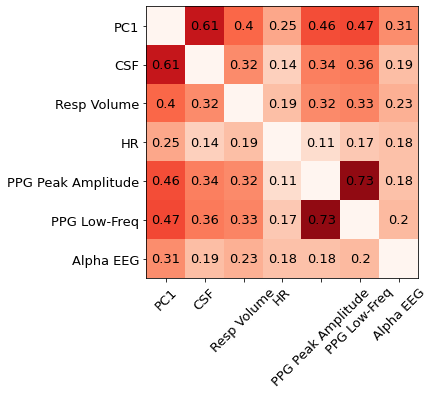

In [181]:
dataset = 'chang'
subject_list = subj_dict[dataset]
subject_load = data_load_dict[dataset]
subject_pc = pca_dict[dataset]
physio_labels = physio_dict[dataset]
new_labels = [physio_label_dict[p] for p in physio_labels]

lag_vec = np.arange(lag_n[dataset]+1)

basis_group = [[] for i in range(len(physio_labels))]
data_group = [[] for i in range(len(physio_labels))]
for i in range(subject_list.shape[0]):
    # Load Subject
    if dataset == 'chang':
        subj, scan = subject_list.iloc[i, 0], subject_list.iloc[i, 1]
        df = subject_load(subj, scan, subject_pc[0][f'{subj}_{scan}'], 
                            subject_pc[1][f'{subj}_{scan}'], sf_dict[dataset])
    elif dataset == 'spreng':
        subj = subject_list.iloc[i, 1]
        df = subject_load(subj, subject_pc[0][subj], 
                            subject_pc[1][subj], sf_dict[dataset]) 
    elif dataset == 'hcp':
        subj = subject_list.iloc[i, 0]
        df = subject_load(subj, subject_pc[0][str(subj)], 
                            subject_pc[1][str(subj)], sf_dict[dataset]) 
    
    # Create a separate dataframe for modeling w/ lag splines
    nknots=3
    for i, p in enumerate(physio_labels):
        basis, lag_spline = lag_basis(df[p], lag_vec, nknots)
        # Trim NaNs introduced from lag splines
        na_indx = ~(np.isnan(basis).any(axis=1))
        basis_z = zscore(basis[na_indx, :])
        basis_group[i].append(basis_z)
        data_group[i].append(zscore(df[p].loc[na_indx]))

basis_group = [np.vstack(g) for g in basis_group]
data_group = [np.hstack(g).T for g in data_group]


# Fit MCCA
mcca = MCCA(latent_dims=3, random_state=0)
mcca.fit(basis_group)

# Print average pair-wise correlation
print(mcca.score(basis_group))


# Plot correlation matrix
corr_mat = mcca.correlations(basis_group)

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=new_labels, index=new_labels)
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.8, cmap='Reds')
ax.set_xticks(np.arange(len(physio_labels)))
ax.set_yticks(np.arange(len(physio_labels)))
ax.set_xticklabels(new_labels, rotation=45, fontsize=13)
ax.set_yticklabels(new_labels, fontsize=13)

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center', fontsize=13)
# plt.colorbar(im, ax=ax)


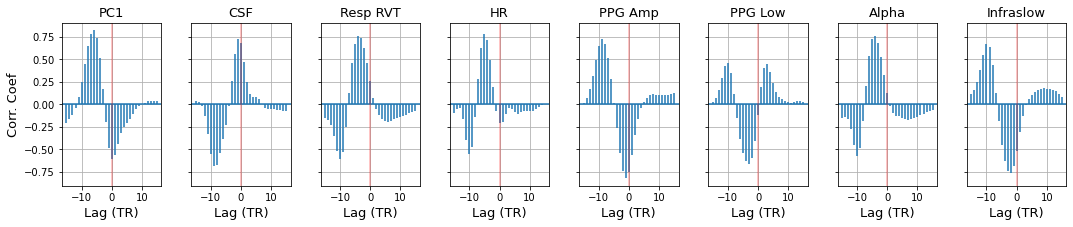

In [9]:
# Plot lags on first canonical component
cca_pred = mcca.transform(basis_group)

# if (dataset == 'hcp') | (dataset == 'spreng'):
#     cca_pred = [cca_pred[i]*-1 for i in range(len(physio_labels))] 

cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(len(physio_labels))]).T,
    columns = new_labels
)

fig, axs = plt.subplots(nrows=1, ncols=len(physio_labels), figsize=(18,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.3)

for i, ax in enumerate(axs):
    ax.xcorr(data_group[i], cca_pred[i][:, 0], maxlags=lag_n[dataset]+5)
    ax.set_xlabel('Lag (TR)', fontsize=13)
    ax.set_title(new_labels[i], fontsize=13)
    ax.axvline(0, 0, 1, alpha=0.3, color='red')
    if i == 0:
        ax.set_ylabel('Corr. Coef', fontsize=13)
    ax.grid(True)
    

# 4. Respiration Task Analysis

## 4.1 Chang Cued-Inspiration Task

### 4.1.1. Create Breathe Onset Blocks

In [4]:
bh_events = load_chang_bh_event_file()
bh_event_blocks = construct_deep_breath_blocks(bh_events, 2.1)
bh_event_blocks = [tuple(b) for b in bh_event_blocks]
breath_onsets_tr = [block[0] for block in bh_event_blocks]

### 4.1.2 Load Trial-Level Compliance CSV

In [5]:
compliance = pd.read_csv('data/dataset_chang_bh/compliance.csv')
compliance = compliance.set_index(
    compliance['subject'].astype(str) + '_' + compliance['scan'].astype(str)
)
trial_cols = [f'trial{n+1}' for n in range(9)]

### 4.1.3 Across-Subject Trial Average

(-1.5, 1.5)

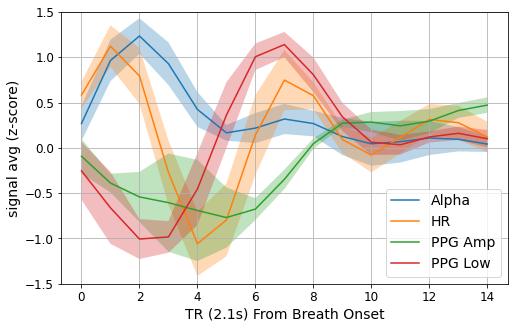

In [6]:
# Specify subject scans
subj_scan_dict = {
    15: [9, 15],
    17: [6, 15],
    19: [16, 22],
    20: [12],
    21: [9],
    25: [12]
}

physio_select = ['Alpha', 'PPG_HR_NK', 'PPG_PEAK_AMP', 'PPG_LOW_NK']
physio_labels = ['Alpha', 'HR', 'PPG Amp', 'PPG Low']

# physio_select = ['pc1', 'csf']
# physio_labels = ['PC1', 'CSF']

physio_list = [[] for i in range(len(physio_select))]

for subj in subj_scan_dict:
    physio_block_list = [[] for i in range(len(physio_select))]
    # Concatenate trials across scans from the same subject
    for scan in subj_scan_dict[subj]: 
        if scan < 10:
            scan_str = f'000{scan}'
        else:
            scan_str = f'00{scan}'
        df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang_bh[f'{subj}_{scan}'], 
                                     pc_p_subj_chang_bh[f'{subj}_{scan}'], 
                                     pc_c_subj_chang_bh[f'{subj}_{scan}'],
                                     fs_chang)
        # Load compliance for scan
        scan_compliance = compliance.loc[f'{subj}_{scan}'][trial_cols].values
        # Filter out non-compliant trials
        scan_event_blocks = [block for block, c in zip(bh_event_blocks, scan_compliance) if c == 1]

        for i, p in enumerate(physio_select):
            p_ts = df_subj[p].values[np.newaxis, :]
            physio_block_list[i].append(np.squeeze(p_ts[:,scan_event_blocks]))
    # Concatenate trials across scans
    physio_block_list = [np.vstack(p_blocks) for p_blocks in physio_block_list]
    for i, p in enumerate(physio_select):
        physio_list[i].append(physio_block_list[i])

# Concatenate trials across all subjects
physio_trials = [np.vstack(p) for p in physio_list]
physio_avg = [np.mean(p_trials, axis=0) for p_trials in physio_trials]
n_trials = len(physio_trials[0])

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(6), 6)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])
perms_avg_array = np.stack(perms_avg, axis=2)  
physio_se = np.std(perms_avg_array, axis=2)


fig, ax = plt.subplots(figsize=(8,5))
trial_len = len(physio_avg[0])
for p_avg, p_se, p_label in zip(physio_avg, physio_se, physio_labels):
    ax.plot(np.arange(trial_len), p_avg, label=p_label)
    ax.fill_between(np.arange(trial_len), p_avg-p_se, p_avg+p_se, alpha=0.3)



ax.legend(fontsize=14)
ax.grid(True)
ax.set_xlabel('TR (2.1s) From Breath Onset', fontsize=14)
ax.set_ylabel('signal avg (z-score)', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_ylim(-1.5,1.5)

### 4.1.4 Across-Subject Evoked Power Average

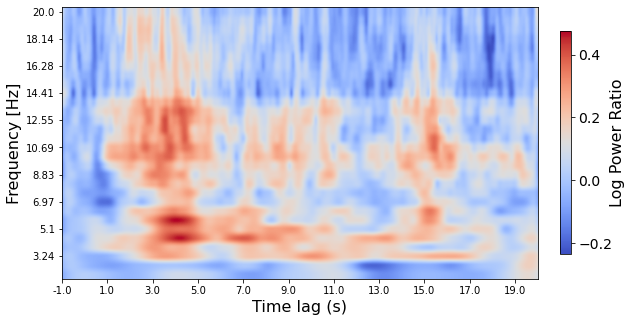

In [41]:
# Load breathhold event timing
events = np.loadtxt(f'data/dataset_chang_bh/adb_onsets.txt')
events = events - 14.7 
# Specify upper and lower limits of frequency range
freqs = np.linspace(2,20, 30)
# Select EEG channels 
eeg_chan_avg = ['P3', 'P4', 'Pz', 'O1','O2','Oz']
# Loop through subjects and calculate evoked power
power_group = []
for subj, scan in subject_list_chang_bh[['subject','scan']].values.tolist():
    if scan < 10:
        scan_str = f'000{scan}'
    else:
        scan_str = f'00{scan}'
    raw = mne.io.read_raw_fif(f'data/dataset_chang_bh/eeg/raw/sub_00{subj}_mr_{scan_str}.raw.fif', preload=True, 
                              verbose=False)
    # Crop first 14.7s to match functional scans
    raw.crop(tmin=14.7)
    # raw.set_eeg_reference(ref_channels=['Fz'])
    raw.pick(eeg_chan_avg)
    
    # Only average trials where the subject took a breath
    subj_compliance = compliance.loc[f'{subj}_{scan}'][trial_cols]
    breath_annot = mne.Annotations(onset=events,  # in seconds
                                   duration=10,  # in seconds, too
                                   description=['BREATH' if i == 1 else 'bad BREATH' for i in subj_compliance])
    raw.set_annotations(breath_annot)
    events_mne, event_annot = mne.events_from_annotations(raw, verbose=False)
    epochs = mne.Epochs(raw, events_mne, 1, -1, 20, reject_by_annotation = True, 
                        baseline = None, verbose=False)
    n_cycles = 15 # number of cycles parameter for wavelet
    # Commented out multitaper power estimation
    # time_bandwidth = 4.0  
    # power = tfr_multitaper(epochs, freqs=freqs, n_cycles=n_cycles,
    #                        time_bandwidth=time_bandwidth, return_itc=False, 
    #                        average=True)
    # Morlet wavelet evoked power average
    power_avg = tfr_morlet(epochs, freqs=freqs, n_cycles=n_cycles, return_itc=False, average=True)
    # apply baseline (log-ratio - decibels)
    power_avg.apply_baseline(baseline=(-1, 0), mode='logratio', verbose=False)
    times = power_avg.times
    # Convert to Pandas dataframe for further processing
    power_df = power_avg.to_data_frame(index=None)
    power_df['freq_indx'] = power_df.groupby('freq').transform('cumcount')
    power_df['avg_chan'] = power_df[eeg_chan_avg].mean(axis=1)
    power_df['subj'] = f'{subj}_{scan}'
    power_group.append(power_df[['subj', 'time','freq','freq_indx', 'avg_chan']])

# Concatenate subject evoked power averages across subjects
power_group = pd.concat(power_group, axis=0)

# Across-subject evoked power average
power_group_avg = power_group.groupby(['freq', 'freq_indx'])['avg_chan'].mean()
power_group_avg = power_group_avg.unstack().values

# Plot 
fig, ax = plt.subplots(figsize=(10,5))
im = ax.imshow(power_group_avg[::-1, :], aspect=40, cmap='coolwarm')

t_sample = np.arange(0,len(times), 200)
ax.set_xticks(t_sample)
ax.set_xticklabels(times[t_sample])
ax.set_xlabel('Time lag (s)', fontsize=16)

freq_sample = np.arange(0,len(freqs),3)
ax.set_yticks(freq_sample)
ax.set_yticklabels(np.round(freqs[::-1][freq_sample],2))
ax.set_ylabel('Frequency [Hz]', fontsize=16)
cbar = plt.colorbar(im,fraction=0.02, pad=0.04)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('Log Power Ratio', fontsize=16, labelpad=-2)

plt.show()

## 4.2 NKI Breath-Hold Task - Scan Average

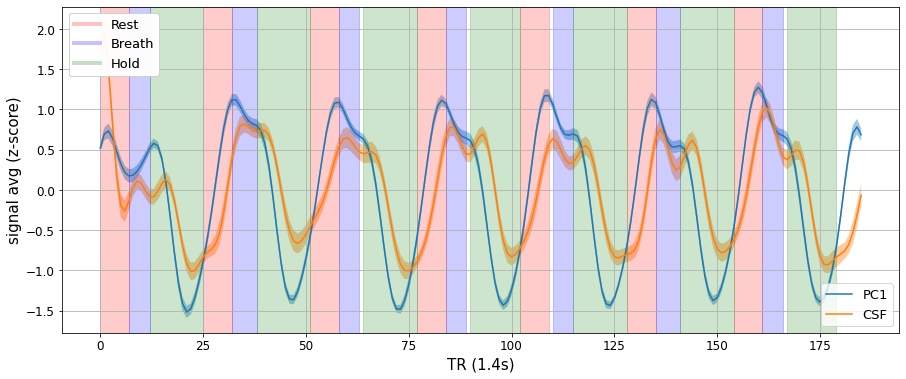

In [8]:
# physio_select = ['PPG_HR_NK', 'PPG_PEAK_AMP', 'PPG_LOW_NK', 'GSR']
# physio_labels = ['HR', 'PPG Amp', 'PPG Low', 'SC']

physio_select = ['pc1', 'csf']
physio_labels = ['PC1', 'CSF']
physio_list = [[] for i in range(len(physio_select))]
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], fs_nki, norm=True)
    for i, p in enumerate(physio_select):
        physio_list[i].append(df[p].values)

physio_avg_list = [np.mean(physio_list[i], axis=0) for i in range(len(physio_select))]
n_t = len(physio_avg_list[0])

# Bootstrap standard errors
physio_array = np.array(physio_list, dtype='object') # makes indexing easier
n_subj = len(physio_list[0])
n_perms = 100
perms_avg = []
for i in range(n_perms):
    perm_sample = np.random.choice(np.arange(n_subj), n_subj)
    physio_trials_perm = [np.vstack(p[perm_sample]) for p in physio_array]
    perms_avg.append([np.mean(p_trials, axis=0) for p_trials in physio_trials_perm])

physio_se_list = []
for i, p in enumerate(physio_list):
    # the np.array call with dtype parameter because the 'object' dtype is carried forward
    # from physio_array
    perms_se = np.vstack([np.array(perm_i[i], dtype='float') for perm_i in perms_avg])
    physio_se_list.append(np.std(perms_se, axis=0))
    
cmap = plt.get_cmap('tab10')
fig, ax = plt.subplots(figsize=(15,6))
for i, (p_avg, p_se) in enumerate(zip(physio_avg_list, physio_se_list)):
    ax.plot(p_avg, color=cmap(i))
    ax.fill_between(np.arange(n_t), p_avg-p_se, p_avg+p_se, alpha=0.4)


lines = ax.get_lines()
legend1 = plt.legend([lines[i] for i in range(len(physio_select))], 
                     physio_labels, 
                     loc=4, fontsize=13)

trial_labels = ['trial_R', 'trial_B', 'trial_H']
trial_colors = ['red', 'blue', 'green']
# Use trial timing from last subject trial timing
for i, trial_l in enumerate(trial_labels):
    blocks = np.array(df[df[trial_l] == 1].index.tolist())
    for b in np.split(blocks, np.where(np.diff(blocks) != 1)[0]+1): 
        ax.axvspan(min(b), max(b), alpha=0.2, color=trial_colors[i])

trial_leg_labels = [Line2D([0], [0], color='red', lw=4, alpha=0.2),
                    Line2D([0], [0], color='blue', lw=4, alpha=0.2),
                    Line2D([0], [0], color='green', lw=4, alpha=0.2)]

legend2 = plt.legend(trial_leg_labels, ['Rest', 'Breath', 'Hold'], loc=2, fontsize=13)
ax.add_artist(legend1)
ax.add_artist(legend2)
ax.set_xlabel('TR (1.4s)', fontsize=15)
ax.set_ylabel('signal avg (z-score)', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True)

## 4.3 NKI Breathhold Task Multiset CCA

[0.41588047 0.40172492 0.12455236]


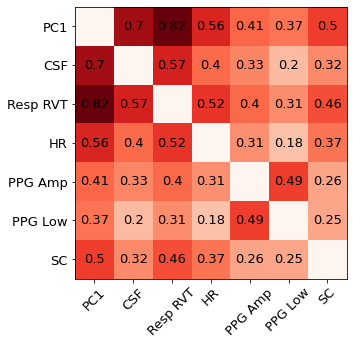

In [298]:
physio_labels = ['pc1', 'csf', 'RESP_RVT_NK', 'PPG_HR_NK', 'PPG_PEAK_AMP', 'PPG_LOW_NK', 'GSR']
new_labels = ['PC1', 'CSF', 'Resp RVT', 'HR', 'PPG Amp', 'PPG Low', 'SC']

lag_vec = np.arange(16)
basis_group = [[] for i in range(len(physio_labels))]
data_group = [[] for i in range(len(physio_labels))]
for i in range(subject_list_nki.shape[0]):
    # Load Subject
    subj = subject_list_nki.iloc[i, 0]
    df = load_subj_nki(subj, pc_subj_nki[f'{subj}'], pc_p_subj_nki[f'{subj}'], fs_nki, norm=True)
    # Create a separate dataframe for modeling w/ lag splines
    nknots=3
    for i, p in enumerate(physio_labels):
        basis, lag_spline = lag_basis(df[p], lag_vec, nknots)
        # Trim NaNs introduced from lag splines
        na_indx = ~(np.isnan(basis).any(axis=1))
        basis_z = zscore(basis[na_indx, :])
        basis_group[i].append(basis_z)
        data_group[i].append(zscore(df[p].loc[na_indx]))

basis_group = [np.vstack(g) for g in basis_group]
data_group = [np.hstack(g).T for g in data_group]


# Fit MCCA
mcca = MCCA(latent_dims=3, random_state=0)
mcca.fit(basis_group)

# Print average pair-wise correlation
print(mcca.score(basis_group))


# Plot correlation matrix
corr_mat = mcca.correlations(basis_group)

corr_mat = pd.DataFrame(corr_mat[:,:,0], columns=new_labels, index=new_labels)
corr_mat_array = corr_mat.values
np.fill_diagonal(corr_mat_array, 0)

fig, ax = plt.subplots(figsize=(8,5))
im = ax.imshow(corr_mat_array, vmin=0, vmax=0.8, cmap='Reds')
ax.set_xticks(np.arange(len(physio_labels)))
ax.set_yticks(np.arange(len(physio_labels)))
ax.set_xticklabels(new_labels, rotation=45, fontsize=13)
ax.set_yticklabels(new_labels, fontsize=13)

for (j,i),label in np.ndenumerate(corr_mat):
    if i != j:
        ax.text(i,j,round(label,2),ha='center',va='center', fontsize=13)
# plt.colorbar(im, ax=ax)


In [305]:
from scipy.signal import csd
pred_signal1 = cca_pred[3][:,0]
pred_signal2 = cca_pred[3][:,1]

cca_pred = mcca.transform(basis_group)

f, pxy = csd(pred_signal1, pred_signal2, 1, return_onesided=True)

f_indx = np.where((f>0.05) & (f<0.1))
np.angle(pxy)[f_indx]

array([ 1.66829923,  1.63848882,  1.61249084,  1.6415359 ,  1.61561553,
        1.58026707,  1.52256186,  1.49282491,  1.5019581 ,  1.39818288,
        1.273745  , -0.97407616, -2.16414878])

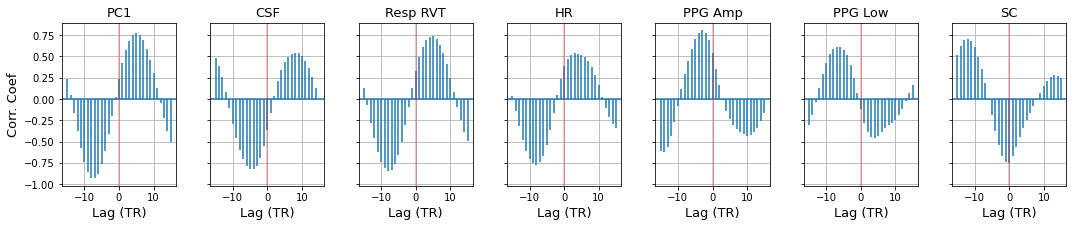

In [24]:
# Plot lags on first canonical component
cca_pred = mcca.transform(basis_group)

    
cca_pred_df = pd.DataFrame(
    np.vstack([cca_pred[i][:,0] for i in range(len(physio_labels))]).T,
    columns = new_labels
)

fig, axs = plt.subplots(nrows=1, ncols=len(physio_labels), figsize=(18,3), sharey=True, sharex=True)
fig.subplots_adjust(wspace=0.3)

for i, ax in enumerate(axs):
    ax.xcorr(data_group[i], cca_pred[i][:, 0], maxlags=15)
    ax.set_xlabel('Lag (TR)', fontsize=13)
    ax.set_title(new_labels[i], fontsize=13)
    ax.axvline(0, 0, 1, alpha=0.3, color='red')
    if i == 0:
        ax.set_ylabel('Corr. Coef', fontsize=13)
    ax.grid(True)
    

# 5. Vigilance Modulation of Global Bold and Respiration Time Courses

## 5.1 Amplitude Analysis

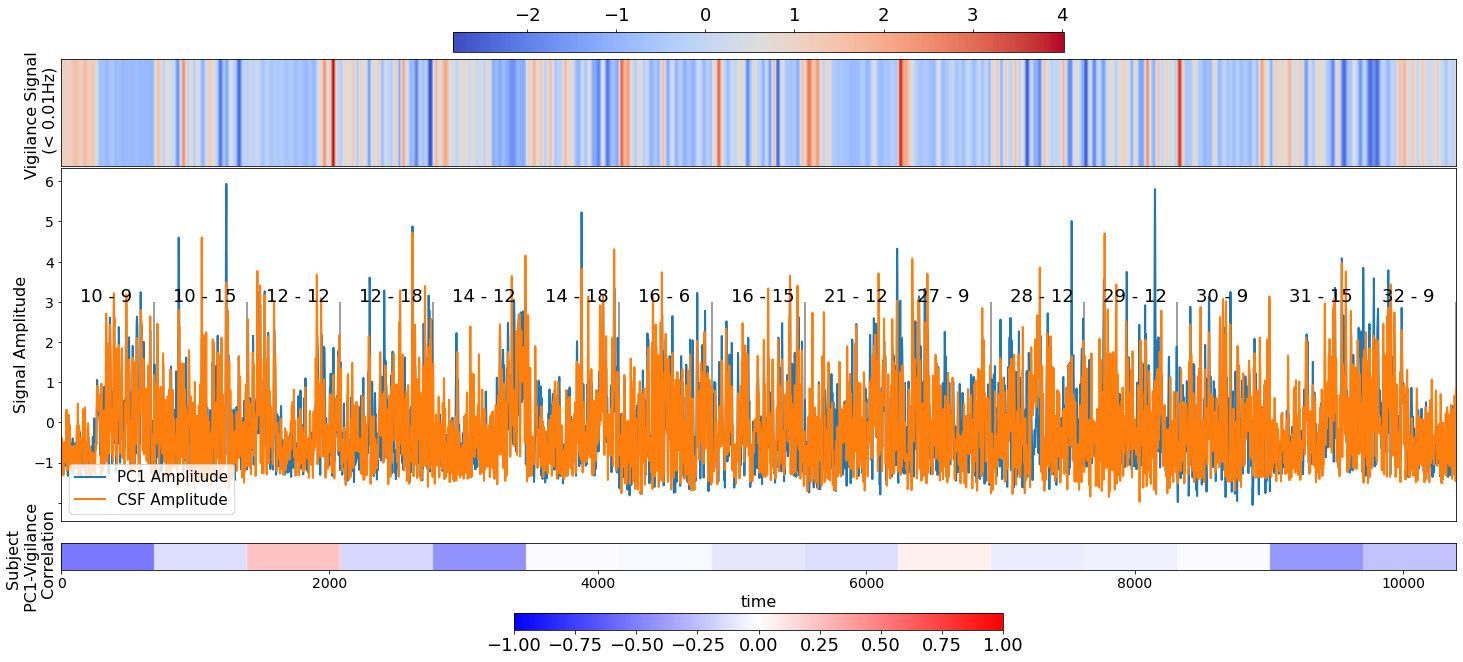

In [411]:
df_group = []
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'],
                         fs_chang)
    # Create amplitude time series
    # df['PC1_AMP'] = butterworth_filter(
    #     np.abs(hilbert(df['pc1'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    # )
    # df['CSF_AMP'] = butterworth_filter(
    #     np.abs(hilbert(df['csf'])), None, 0.01, fs=fs_chang, filter_type='lowpass'
    # )
    df['PC1_AMP'] = np.abs(hilbert(df['pc1']))
    df['CSF_AMP'] = np.abs(hilbert(df['csf']))
    # Normalize values within subject 
    df = df.apply(zscore, axis=0)

    # correlate vigilance and CSF AMP and PC AMP for viz
    df['corr_vigilance_CSF'] = df[['CSF_AMP', 'vigilance_at']].corr().iloc[0,1]
    df['corr_vigilance_PC1'] = df[['PC1_AMP', 'vigilance_at']].corr().iloc[0,1]
    # supply meta information
    df['subj'] = subj
    df['sleep_flag'] = sleep
    df['scan'] = scan
    df['subj_scan'] = df['subj'].astype(str) + '-' + df['scan'].astype(str)
    
    df_group.append(df)

df_concat = pd.concat(df_group, axis=0, ignore_index=True)

# Plot figure
fig = plt.figure(figsize=(25,11), constrained_layout=False)
gspec = fig.add_gridspec(3,1, hspace=0, height_ratios=[0.25, 0.65, 0.2])
ax = fig.add_subplot(gspec[0])
im1 = ax.imshow(df_concat['vigilance_at_low'].values[np.newaxis,:], label='Vigilance', cmap='coolwarm', aspect=800)
ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel('Vigilance Signal \n (< 0.01Hz)', fontsize=16)
cbar = plt.colorbar(im1, ax=ax, orientation='horizontal', location='top', aspect=30)
cbar.ax.tick_params(labelsize=18)


ax = fig.add_subplot(gspec[1])
df_concat['PC1_AMP'].plot(ax=ax, linewidth=2, label='PC1 Amplitude')
df_concat['CSF_AMP'].plot(ax=ax, linewidth=2, label='CSF Amplitude')
ax.set_xlim([0, df_concat.shape[0]])
ax.set_xticks([])
ax.set_ylabel('Signal Amplitude', fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=14)
plt.setp(ax.get_yticklabels()[1], visible=False)


n = 0
for i, (subj, scan) in enumerate((zip(subject_list_chang.subject, subject_list_chang.scan))):
    n += 693
    ax.vlines(n, 0, 3, color='black', alpha=0.5)
    ax.text(n-550, 3, f'{subj} - {scan}', fontsize=18)
    
ax.legend(fontsize=15, loc='lower left')

ax = fig.add_subplot(gspec[2])
im2 = ax.imshow(df_concat['corr_vigilance_PC1'].values[np.newaxis,:], label='Subject PC1-Vigilance Correlation', 
          cmap='bwr', aspect=200, vmin=-1, vmax=1)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.set_xlabel('time', fontsize=16)
ax.set_ylabel('Subject \n PC1-Vigilance \n Correlation', fontsize=16)
ax.set_yticks([])
cbar = plt.colorbar(im2, ax=ax, orientation='horizontal', location='bottom', aspect=30, pad=0.4)
cbar.ax.tick_params(labelsize=18)

plt.show()

In [414]:
# calculate correlation between ultra low-frequency time series
physio_select = ['RESP_RVT_NK_low', 'PC1_AMP', 'CSF_AMP', 'vigilance_at']
orig_corr = np.corrcoef(df_concat[physio_select].values.T)
# run permutation test on ultra low-frequency time series correlations
n_perm = 1000
n_len = chang_len # defined in cell 1.2
perm_corr = []
df_perm = [df_subj[physio_select].copy() for df_subj in df_group]
for n in range(n_perm):
    perm_nshift = [np.random.randint(1, n_len, len(physio_select)) for i in range(len(df_group))]
    perm_roll = [[np.roll(np.arange(chang_len), n_shift) for n_shift in perm_nshift_subj] 
                 for perm_nshift_subj in perm_nshift]
    p_perm_concat = []
    for df_subj, perm_subj in zip(df_perm, perm_roll):
        p_perm = [df_subj.iloc[perm, df_subj.columns.get_loc(p)].values for p, perm in zip(physio_select, perm_subj)]
        p_perm = np.stack(p_perm, axis=1) 
        p_perm_concat.append(p_perm)
    p_perm_concat = np.vstack(p_perm_concat)
    perm_corr.append(np.corrcoef(p_perm_concat.T))

# append original correlations to permutation distribution
perm_corr = [orig_corr] + perm_corr

perm_corr = np.stack(perm_corr, axis=2)
orig_corr_stacked = np.stack([orig_corr]*perm_corr.shape[2], axis=2)
perm_corr_percentile = np.sum(np.abs(perm_corr) >= np.abs(orig_corr_stacked), axis=2) / perm_corr.shape[2]


In [415]:
df_concat[physio_select].corr()

,RESP_RVT_NK_low,PC1_AMP,CSF_AMP,vigilance_at
RESP_RVT_NK_low,1.000000,-0.197167,-0.139042,0.305746
PC1_AMP,-0.197167,1.000000,0.556110,-0.134397
CSF_AMP,-0.139042,0.556110,1.000000,-0.129775
vigilance_at,0.305746,-0.134397,-0.129775,1.000000


In [410]:
df_concat[['vigilance_at','RESP_RVT_NK', 'pc1']].corr()

,vigilance_at,RESP_RVT_NK,pc1
vigilance_at,1.000000,0.116197,-0.076750
RESP_RVT_NK,0.116197,1.000000,0.160138
pc1,-0.076750,0.160138,1.000000


## 7.2 Vigilance and Respiration Interaction Analysis

### 7.2.1 Load Data (Chang)

In [318]:
df_model_group = []
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
    # Create lag spline regressors
    lag_vec = np.arange(11)
    nknots=3
    rv_basis, lag_spline = lag_basis(df['RESP_RVT_NK'], lag_vec, nknots)
    pc_basis, lag_spline = lag_basis(df['pc1'], lag_vec, nknots)

    # Trim NaNs introduced by lag splines
    na_indx = ~(np.isnan(rv_basis).any(axis=1))
    df_model_rv = pd.DataFrame(zscore(rv_basis[na_indx, :]), 
                               columns = [f'RV_Knot_{i}' for i in range(nknots)])
    df_model_pc1 = pd.DataFrame(zscore(pc_basis[na_indx, :]), 
                               columns = [f'PC_Knot_{i}' for i in range(nknots)])
    df_model = pd.concat([df_model_rv, df_model_pc1], axis=1)
    # supply meta-information
    df_model['subj'] = subj
    df_model['scan'] = scan
    df_model['pc1'] = df['pc1'].loc[na_indx].values
    df_model['vigilance_at'] = df['vigilance_at_low'].loc[na_indx].values
    # df_model['vigilance_at'] = df['vigilance_at'].loc[na_indx].values
    df_model_group.append(df_model)

df_model_group = pd.concat(df_model_group, axis=0, ignore_index=True)

### 7.2.2 Fit Model

In [319]:
full_pred = df_model_group[['RV_Knot_0', 'RV_Knot_1', 'RV_Knot_2']]
test = [full_pred.iloc[:,i].values*df_model_group['vigilance_at'].values for i in range(full_pred.shape[1])]
test_df = pd.DataFrame(test, index=[f'{col}_i' for col in full_pred.columns]).T

full_pred_i = pd.concat([full_pred, test_df], axis=1)
full_pred_i['vigilance'] = df_model_group['vigilance_at'].values

pc_norm = zscore(df_model_group['pc1'])

va = sm.cov_struct.Autoregressive()
sm_fit_i = sm.GEE(pc_norm, full_pred_i, groups=df_model_group.subj, cov_struct=va).fit()
sm_fit_i.summary()

/Users/taylorbolt/opt/miniconda3/envs/eeg_fmri/lib/python3.9/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                         pc1   No. Observations:                10245
Model:                                 GEE   No. clusters:                       11
Method:                        Generalized   Min. cluster size:                 683
                      Estimating Equations   Max. cluster size:                1366
Family:                           Gaussian   Mean cluster size:               931.4
Dependence structure:       Autoregressive   Num. iterations:                    26
Date:                     Fri, 11 Nov 2022   Scale:                           0.844
Covariance type:                    robust   Time:                         15:48:18
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
RV_Knot_0       0.0651      0.057      1.142      0.254      -0.047       0.177
RV_Knot_1      -0.3822      0.045     -8.553      0.000      -0.470      -0.295
RV_Knot_2       0.0319      0.037      0.860      0.390      -0.041       0.105
RV_Knot_0_i    -0.0151      0.036     -0.422      0.673      -0.085       0.055
RV_Knot_1_i     0.1197      0.020      5.852      0.000       0.080       0.160
RV_Knot_2_i    -0.0150      0.014     -1.089      0.276      -0.042       0.012
vigilance       0.0076      0.006      1.380      0.168      -0.003       0.019
==============================================================================
Skew:                         -0.1978   Kurtosis:                       0.9860
Centered skew:                -0.1966   Centered kurtosis:              0.9829
==============================================================================
"""

### 7.2.3 Plot Interaction Results

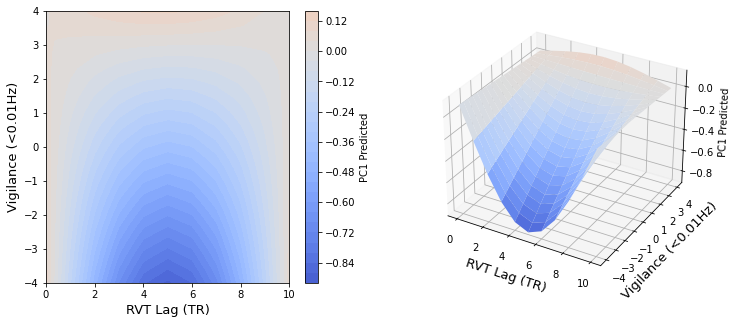

In [320]:
vigilance_eval = np.linspace(-4,4,20)
var_eval = 1 # 1 std above mean
rv_grid = []
rv_grid_conf = []
for v in vigilance_eval:
    pred_list = [var_eval * lag_spline.iloc[:, l].values for l in range(lag_spline.shape[1])]
    pred_mat = np.vstack(pred_list).T
    pred_mat_i = np.vstack([pred_mat[:,i]*v for i in range(full_pred.shape[1])]).T

    pred_mat_full = np.hstack([pred_mat, pred_mat_i, np.repeat(v,11)[:, np.newaxis]])

    # Get predictions from model
    pred_lags = sm_fit_i.predict(pred_mat_full)
    pred_obj = sm_fit_i.get_prediction(pred_mat_full)
    rv_grid.append(pred_lags)
    rv_grid_conf.append(pred_obj.summary_frame(alpha=0.05))

rv_grid = np.array(rv_grid)

fig = plt.figure(figsize=(12,5))
lags = np.arange(11)
x_mesh = np.meshgrid(lags, vigilance_eval)
# First subplot
ax = fig.add_subplot(1, 2, 1)
im = ax.contourf(x_mesh[0], x_mesh[1], rv_grid, 30, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('RVT Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
plt.colorbar(im, label='PC1 Predicted')

# Second subplot
ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.plot_surface(x_mesh[0], x_mesh[1], rv_grid, cmap='coolwarm', vmin=-1, vmax=1)
ax.set_xlabel('RVT Lag (TR)', fontsize=13)
ax.set_ylabel('Vigilance (<0.01Hz)', fontsize=13)
ax.set_zlabel('PC1 Predicted')
plt.show()

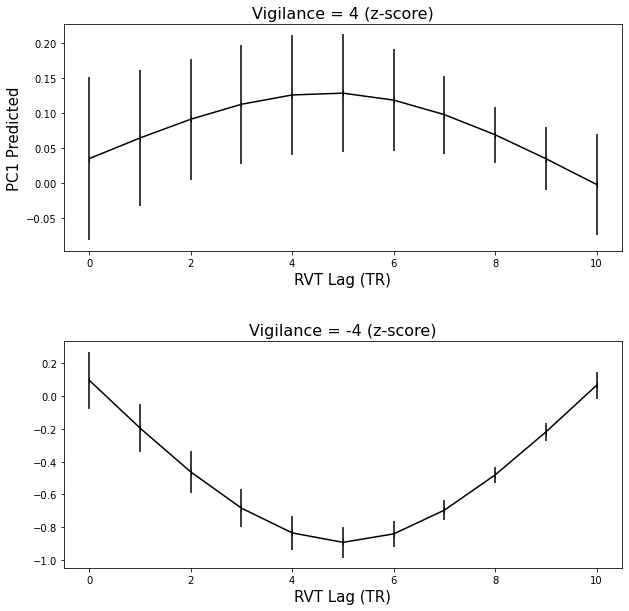

In [47]:
fig = plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.4)
lags = np.arange(11)
# First subplot
ax = fig.add_subplot(2, 1, 1)
ax.plot(lags, rv_grid_conf[-1]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[-1]['mean'], yerr=rv_grid_conf[-1]['mean_se'], fmt='|', color='black')
ax.set_xlabel('RVT Lag (TR)', fontsize=15)
ax.set_ylabel('PC1 Predicted', fontsize=15)
ax.set_title('Vigilance = 4 (z-score)', fontsize=16)

# Second subplot
ax = fig.add_subplot(2, 1, 2)
ax.plot(lags, rv_grid_conf[0]['mean'], color='black')
ax.errorbar(lags, rv_grid_conf[0]['mean'], yerr=rv_grid_conf[0]['mean_se'], fmt='|', color='black')
ax.set_xlabel('RVT Lag (TR)', fontsize=15)
ax.set_title('Vigilance = -4 (z-score)', fontsize=16)
plt.show()



# 6. Hemodynamic Modeling of Respiration Response

## 6.1 Positive Respiratory Volume

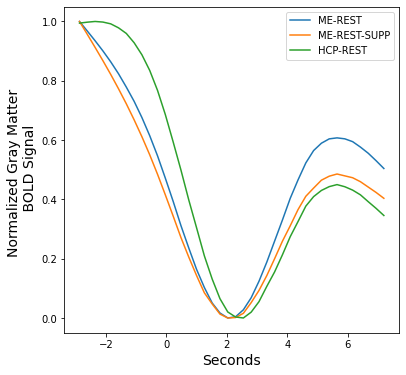

In [392]:
# res_fp = ['results/physio_glm_dlnm/chang_dlnm_group_results.pkl', 
#           'results/physio_glm_dlnm/spreng_dlnm_group_results.pkl', 
#           'results/physio_glm_dlnm/hcp_fix_dlnm_group_results_w45.pkl']
# nifti_fp = ['results/physio_glm_dlnm/chang_dlnm_group_eval_6.nii', 
#             'results/physio_glm_dlnm/spreng_dlnm_group_eval_6.nii', 
#             'results/physio_glm_dlnm/hcp_fix_dlnm_group_eval_6_w45.nii']

res_fp = ['spreng_dlnm_group_results.pkl', 
          'spreng_dlnm_group_results.pkl', 
          'spreng_dlnm_group_results.pkl']
nifti_fp = ['spreng_dlnm_group_eval_5.nii', 
            'spreng_dlnm_group_eval_4.nii', 
            'spreng_dlnm_group_eval_0.nii']

nifti_t_samples = [
    (2,10),
    (0,9),
    (4,12)
]
dataset_label = ['ME-REST', 'ME-REST-SUPP', 'HCP-REST']
# data_fs = [fs_chang, fs_spreng, fs_hcp]
data_fs = [fs_hcp, fs_hcp, fs_hcp]

fig, ax = plt.subplots(figsize=(6,6))
dlnlm_res_time = []
for res_obj, nifti_resp, fs_tmp, label in zip(res_fp, nifti_fp, data_fs, dataset_label):
    data_tr = 1/fs_tmp
    dlnlm_res = pickle.load(open(res_obj, 'rb'))
    nifti = nb.load(nifti_resp, keep_file_open = True)
    mask = nb.load('masks/MNI152_T1_3mm_gray_mask.nii.gz').get_fdata()
    nifti_data = nifti.get_fdata()
    nifti.uncache()
    nifti_data = convert_2d(mask, nifti_data)
    nifti_mean = nifti_data.mean(axis=1)

    # Min-Max Scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    nifti_mean_scaled = min_max_scaler.fit_transform(nifti_mean[:, np.newaxis])
    ax.plot(dlnlm_res[1]*data_tr, nifti_mean_scaled, label=label)
    # ax.plot(dlnlm_res[1]*data_tr, nifti_mean, label=label)
    dlnlm_res_time.append(dlnlm_res[1])

# jitter = [-2, -2.5]
# for t, j in enumerate(jitter):
#     t_samples = [dlnlm_res_time[i][nifti_t_samples[i][t]]*(1/data_fs[i]) for i in range(len(nifti_t_samples))]
#     t_min = round(np.min(t_samples),1)
#     t_max = round(np.max(t_samples),1)
#     t_mid = (t_min+t_max)/2
#     ax.axvspan(t_min, t_max, alpha=0.2, color='grey')
#     if t_min == t_max:
#         ax.text(t_mid+j, 1.08, f'{t_min}s', fontsize=16)
#     else:
#         ax.text(t_mid+j, 1.08, f'{t_min}-{t_max}s', fontsize=16)

ax.set_xlabel('Seconds', fontsize=14)
ax.set_ylabel('Normalized Gray Matter \n BOLD Signal', fontsize=14)
ax.legend()
plt.show()
    

In [384]:
dlnlm_res[2]

[0.5, 0.75, 1, 1.5, 2, 2.5]

In [90]:
dlnlm_res = pickle.load(open('results/physio_glm_dlnm/chang_dlnm_group_results.pkl', 'rb'))
(dlnlm_res[1]*2.1)[8]

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


6.892307692307693

## 6.2 Negative Respiratory Volume

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. Th

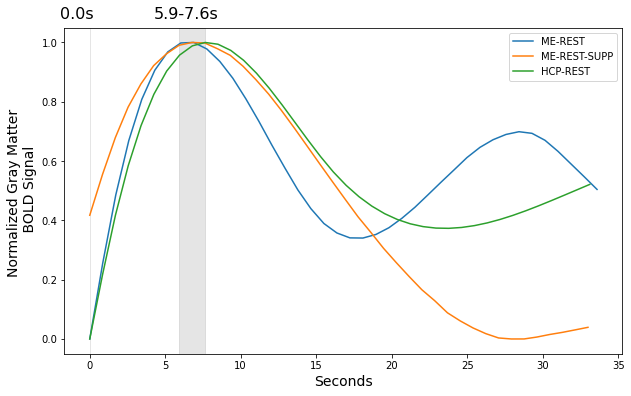

In [92]:
res_fp = ['results/physio_glm_dlnm/chang_dlnm_group_results.pkl', 
          'results/physio_glm_dlnm/spreng_dlnm_group_results.pkl', 
          'results/physio_glm_dlnm/hcp_fix_dlnm_group_results_w45.pkl']
nifti_fp = ['results/physio_glm_dlnm/chang_dlnm_group_eval_0.nii', 
            'results/physio_glm_dlnm/spreng_dlnm_group_eval_0.nii', 
            'results/physio_glm_dlnm/hcp_fix_dlnm_group_eval_1_w45.nii']
nifti_t_samples = [
    (0,8),
    (0,7),
    (0,9)
]
dataset_label = ['ME-REST', 'ME-REST-SUPP', 'HCP-REST']
data_fs = [fs_chang, fs_spreng, fs_hcp]
dlnlm_res_time = []
fig, ax = plt.subplots(figsize=(10,6))
for res_obj, nifti_resp, fs_tmp, label in zip(res_fp, nifti_fp, data_fs, dataset_label):
    data_tr = 1/fs_tmp
    dlnlm_res = pickle.load(open(res_obj, 'rb'))
    nifti = nb.load(nifti_resp, keep_file_open = True)
    mask = nb.load('masks/MNI152_T1_3mm_gray_mask.nii.gz').get_fdata()
    nifti_data = nifti.get_fdata()
    nifti.uncache()
    nifti_data = convert_2d(mask, nifti_data)
    nifti_mean = nifti_data.mean(axis=1)
    # Min-Max Scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    nifti_mean_scaled = min_max_scaler.fit_transform(nifti_mean[:, np.newaxis])
    ax.plot(dlnlm_res[1]*data_tr, nifti_mean_scaled, label=label)
    dlnlm_res_time.append(dlnlm_res[1])

jitter = [-2, -2.5]
for t, j in enumerate(jitter):
    t_samples = [dlnlm_res_time[i][nifti_t_samples[i][t]]*(1/data_fs[i]) for i in range(len(nifti_t_samples))]
    t_min = round(np.min(t_samples),1)
    t_max = round(np.max(t_samples),1)
    t_mid = (t_min+t_max)/2
    ax.axvspan(t_min, t_max, alpha=0.2, color='grey')
    if t_min == t_max:
        ax.text(t_mid+j, 1.08, f'{t_min}s', fontsize=16)
    else:
        ax.text(t_mid+j, 1.08, f'{t_min}-{t_max}s', fontsize=16)
    
ax.set_xlabel('Seconds', fontsize=14)
ax.set_ylabel('Normalized Gray Matter \n BOLD Signal', fontsize=14)
ax.legend()
plt.show()

# 7. Comparison of CPC1 and Respiration Response

/Users/taylorbolt/opt/miniconda3/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 1.0 when using version 1.0.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/modules/model_persistence.html#security-maintainability-limitations
  warnings.warn(


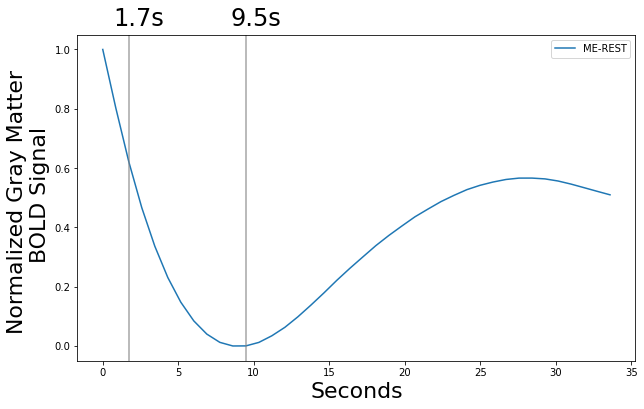

In [182]:
res_fp = []
nifti_fp = []
nifti_t_samples = (2,11)
dataset_label = []
fig, ax = plt.subplots(figsize=(10,6))

data_tr = 1/fs_chang
dlnlm_res = pickle.load(open('results/physio_glm_dlnm/chang_dlnm_group_results.pkl', 'rb'))
nifti = nb.load('results/physio_glm_dlnm/chang_dlnm_group_eval_6.nii', keep_file_open = True)
mask = nb.load('masks/MNI152_T1_3mm_gray_mask.nii.gz').get_fdata()
nifti_data = nifti.get_fdata()
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)
nifti_mean = nifti_data.mean(axis=1)

# Min-Max Scaling
min_max_scaler = preprocessing.MinMaxScaler()
nifti_mean_scaled = min_max_scaler.fit_transform(nifti_mean[:, np.newaxis])
ax.plot(dlnlm_res[1]*data_tr, nifti_mean_scaled, label='ME-REST')

t_sample1 = dlnlm_res[1][nifti_t_samples[0]]*(1/fs_chang)
t_sample2 = dlnlm_res[1][nifti_t_samples[1]]*(1/fs_chang)
ax.axvline(t_sample1, 0, 1, color='grey', alpha=0.7)
ax.axvline(t_sample2, 0, 1, color='grey', alpha=0.7)
ax.text(t_sample1-1, 1.08, f'{np.round(t_sample1,1)}s', fontsize=24)
ax.text(t_sample2-1, 1.08, f'{np.round(t_sample2,1)}s', fontsize=24)

ax.set_xlabel('Seconds', fontsize=22)
ax.set_ylabel('Normalized Gray Matter \n BOLD Signal', fontsize=22)
ax.legend()
plt.show()
    

In [115]:
samples_cpc1 = (22, 29)
samples_dlnlm = (2, 11)

mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz').get_fdata()


nifti_dlnlm = nb.load('results/physio_glm_dlnm/chang_dlnm_group_eval_6.nii', keep_file_open = True)
nifti_dlnlm = nifti_dlnlm.get_fdata()
nifti_dlnlm = convert_2d(mask, nifti_dlnlm)

nifti_cpca = nb.load('results/cpca/chang_cpca_recon_n0.nii', keep_file_open = True)
nifti_cpca = nifti_cpca.get_fdata()
nifti_cpca = convert_2d(mask, nifti_cpca)

print(np.corrcoef(nifti_cpca[samples_cpc1[0],:], nifti_dlnlm[samples_dlnlm[0],:])[0,1])
print(np.corrcoef(nifti_cpca[samples_cpc1[1],:], nifti_dlnlm[samples_dlnlm[1],:])[0,1])

0.870429167304989
0.9326267970937174


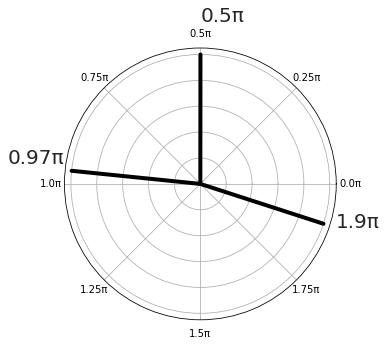

In [181]:
def format_radians_label(float_in):
    # Converts a float value in radians into a
    # string representation of that float
    string_out = str(float_in / (np.pi))+"π"
    
    return string_out

def convert_polar_xticks_to_radians(ax):
    # Converts x-tick labels from degrees to radians
    
    # Get the x-tick positions (returns in radians)
    label_positions = ax.get_xticks()
    
    # Convert to a list since we want to change the type of the elements
    labels = list(label_positions)
    
    # Format each label (edit this function however you'd like)
    labels = [format_radians_label(label) for label in labels]
    
    ax.set_xticklabels(labels)

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection="polar")
ax.set_xticks(np.linspace(0, 2*np.pi, 8, endpoint=False))
convert_polar_xticks_to_radians(ax)
ax.set_yticklabels([])

line_points = [5.97, 1.57, 3.04]
jitter = [1.1, 1.25, 1.5]
# Create polar plot object
with plt.style.context("seaborn-white"):
    # Draw 3 lines
    for j, rad in zip(jitter, line_points):
        ax.plot([rad,rad], [0,1], color="black", linewidth=4)
        ax.text(rad, j, str(np.round(rad / (np.pi), 2))+"π", fontsize=20, weight='bold')

# 8. Supplementary

## 8.1 PPG Power Spectral Density

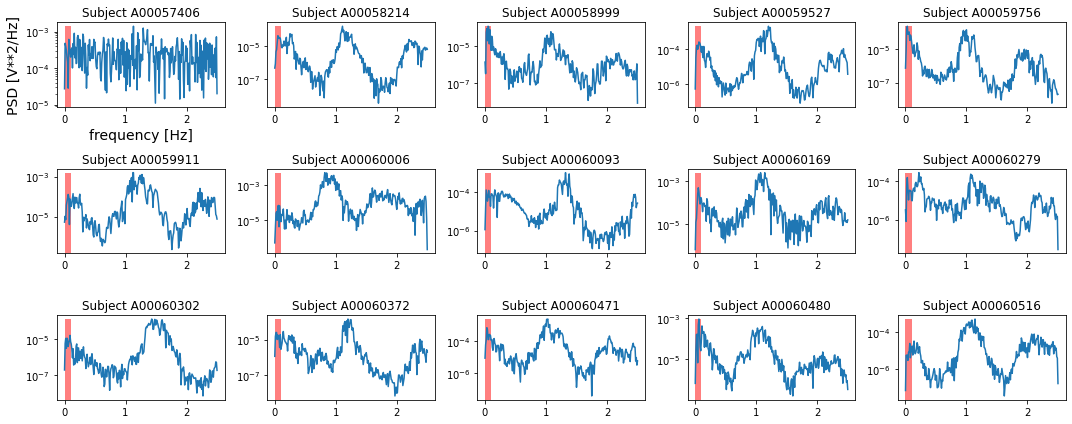

In [13]:
datasets_list = ['chang', 'chang_bh', 'hcp', 'nki']
dataset_subjects = [subject_list_chang, subject_list_chang_bh, subject_list_hcp, subject_list_nki]
sf_resamp = 5 # resampling rate before power spectral densityestimate

dataset = 'nki' # provide string of dataset

subject_list = dataset_subjects[datasets_list.index(dataset)]
# Limit to 15 subjects for larger datasets
if (dataset == 'hcp') | (dataset=='nki'):
    subject_list = subject_list.iloc[:15,:].copy()

fig, axs = plt.subplots(3,5, figsize=(15,6))
for i, ax in zip(range(subject_list.shape[0]), axs.flat):
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        subj, scan = subject_list.iloc[i,:][['subject', 'scan']].astype(int)
        if scan < 10:
            scan_str = f'000{scan}'
        else:
            scan_str = f'00{scan}'  
        
        if dataset == 'chang':
            fp = f'data/dataset_chang/physio/raw/sub_00{subj}-mr_{scan_str}-ecr_echo1_physOUT.mat'
        elif dataset == 'chang_bh':
            fp = f'data/dataset_chang_bh/physio/raw/sub_00{subj}-mr_{scan_str}-adb_echo1_physOUT.mat'
            
        physio_raw = loadmat(fp, squeeze_me=True)      
        
        sf_physio = 1/physio_raw['OUT_p']['dt_phys'].item()
        # Pull physio data into dict
        ppg = physio_raw['OUT_p']['card_dat'].item()
    elif dataset == 'nki':
        subj = subject_list.iloc[i,:]['subject']
        fp = f'data/dataset_nki/physio/raw/{subj}_task_breathhold_physio.tsv.gz'
        physio_df = pd.read_csv(fp, compression='gzip', sep='\t', header=None)
        physio_df = physio_df.dropna(axis=1, how='all')
        subj_base = fp.rsplit('.tsv')[0]
        physio_json = json.load(open(f'{subj_base}.json'))
        physio_df.columns = physio_json['Columns']
        ppg = physio_df['cardiac']
        sf_physio = physio_json['SamplingFrequency']
    elif dataset == 'hcp':
        subj, lr = subject_list.iloc[i,:][['subject', 'lr']]
        physio_signals = np.loadtxt(f'data/dataset_hcp/physio/raw/{subj}_{lr}1_physio.txt')
        ppg = physio_signals[:,2]
        sf_physio = 400        
    
    physio_secs = len(ppg)/sf_physio
    physio_resamp_n = int(physio_secs * 5)
    ppg_resamp = nk.signal_resample(ppg, desired_length=physio_resamp_n, method='FFT')
    f, pxx = welch(ppg_resamp, 5, nperseg=500, noverlap=50)
    ax.semilogy(f, pxx)
    if (dataset == 'chang') | (dataset == 'chang_bh'):
        ax.set_title(f'Subject {subj} - Scan {scan_str}', fontsize=12)
    else:
        ax.set_title(f'Subject {subj}', fontsize=12)

    if i == 0:
        ax.set_xlabel('frequency [Hz]', fontsize=14)
        ax.set_ylabel('PSD [V**2/Hz]', fontsize=14)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)

fig.tight_layout()
plt.show()

## 8.2 PCA Explaned Variance Across Datasets 

### 8.2.1 Standard PCA

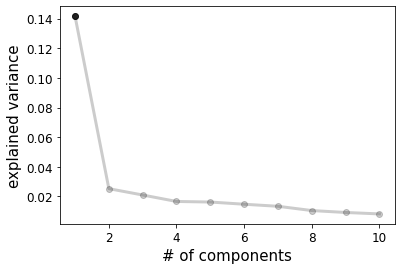

In [232]:
pca_results = [
    'results/pca/chang_pca_group_results.pkl',
    'results/pca/chang_bh_pca_group_results.pkl',
    'results/pca/hcp_fix_pca_group_results.pkl',
    'results/pca/nki_pca_group_results.pkl',
    'results/pca/spreng_pca_group_results.pkl',
    'results/pca/yale_pca_group_results.pkl'
]

exp_var_all = []
for res in pca_results:
    res_tmp = pickle.load(open(res, 'rb'))
    exp_var_all.append(res_tmp['exp_var'])

fig, ax = plt.subplots()

# Select Dataset
e = exp_var_all[5]

ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 11), e[:11], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



### 8.2.2 Complex PCA

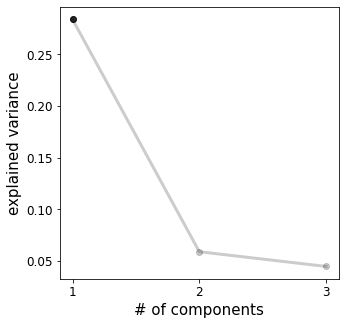

In [14]:
pca_results = [
    'results/cpca/chang_pca_group_c_results.pkl',
    'results/cpca/chang_bh_pca_group_c_results.pkl',
    'results/cpca/hcp_fix_pca_group_c_results.pkl',
    'results/cpca/nki_pca_group_c_results.pkl',
    'results/cpca/spreng_pca_group_c_results.pkl',
    'results/cpca/yale_pca_group_c_results.pkl'
]

exp_var_all = []
for res in pca_results:
    res_tmp = pickle.load(open(res, 'rb'))
    exp_var_all.append(res_tmp['exp_var'])

fig, ax = plt.subplots(figsize=(5,5))

# Select Dataset
e = exp_var_all[5]

ax.plot([1], e[0], '-o', linewidth=3, color='black', alpha=0.8)
ax.plot(np.arange(1, 4), e[:3], '-o', linewidth=3, color='black', alpha=0.2)
ax.set_xlabel('# of components', fontsize=15)
ax.set_xticks(np.arange(1,4))
ax.set_ylabel('explained variance', fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=12)



## 8.3 Subject Time Courses

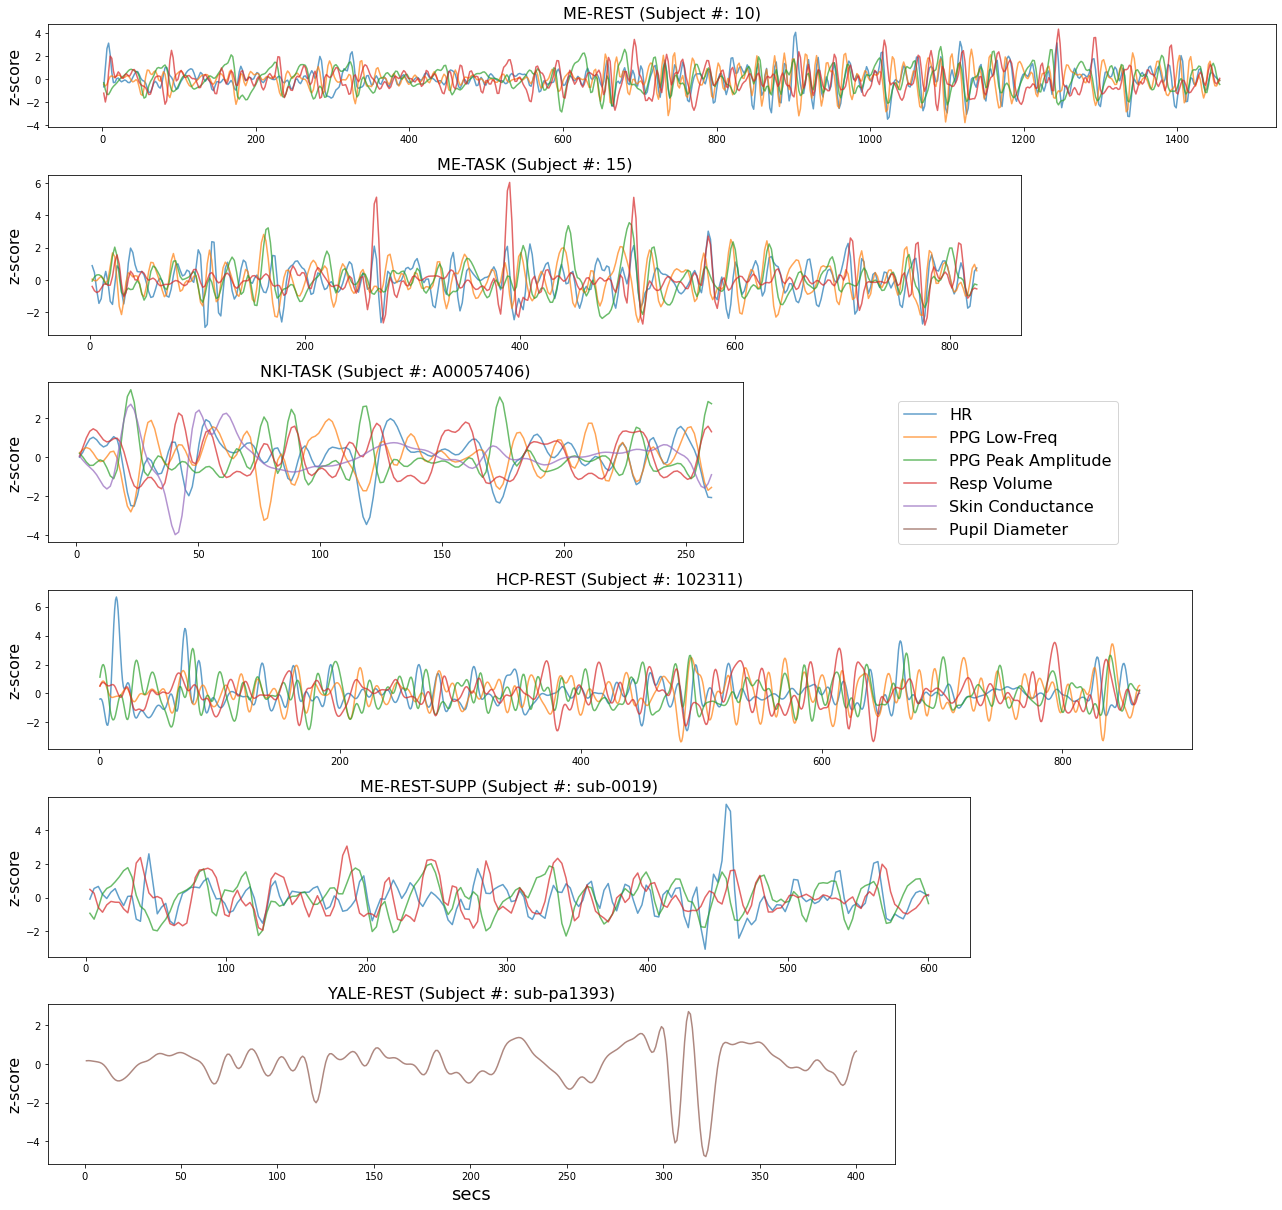

In [113]:
physio_dict = {
    'chang': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'chang_bh': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'nki': ['PPG_HR_NK', 'PPG_LOW_NK' ,'PPG_PEAK_AMP', 'RESP_RVT_NK', 'GSR'],
    'hcp': ['PPG_HR_NK', 'PPG_LOW_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'spreng': ['PPG_HR_NK', 'PPG_PEAK_AMP', 'RESP_RVT_NK'],
    'yale': ['pupil']
}

dataset_aspect_dict = {
    'chang': 15,
    'chang_bh': 15,
    'nki': 8,
    'hcp': 12,
    'spreng': 12,
    'yale': 10
}

fig = plt.figure(figsize=(22,22), constrained_layout=False)
gspec = fig.add_gridspec(6,1, hspace=0.3, height_ratios=None)

cmap = plt.get_cmap('tab10')

physio_color_dict = {
    'PPG_HR_NK': cmap(0),
    'PPG_LOW_NK': cmap(1),
    'PPG_PEAK_AMP': cmap(2),
    'RESP_RVT_NK': cmap(3),
    'GSR': cmap(4),
    'pupil': cmap(5)
}

subj_indx = 0
for i, d in enumerate(subj_dict):
    subj_list = subj_dict[d]
    if d in ['chang', 'chang_bh', 'yale']:
        if d in ['chang', 'chang_bh']:
            subj, scan = int(subj_list.iloc[i]['subject']), int(subj_list.iloc[i]['scan'])
        elif d == 'yale':
            subj, scan = subj_list.iloc[i]['subject'], int(subj_list.iloc[i]['scan'])
            
        df_subj = data_load_dict[d](subj, scan, pca_dict[d][0][f'{subj}_{scan}'], 
                                    pca_dict[d][1][f'{subj}_{scan}'], sf_dict[d])
    else:
        subj = subj_list.iloc[subj_indx,:]['subject']
        df_subj = data_load_dict[d](subj, pca_dict[d][0][f'{subj}'], 
                                    pca_dict[d][1][f'{subj}'], sf_dict[d])

    ax = fig.add_subplot(gspec[i])
    ax.set_aspect(dataset_aspect_dict[d], anchor='SW')
    
    x = np.arange(1, df_subj.shape[0]+1)*(1/sf_dict[d])
    for p in physio_dict[d]:
        ax.plot(x, df_subj[p], color=physio_color_dict[p], alpha=0.7, label=physio_label_dict[p])
        
    ax.set_title(f'{label_dict[d]} (Subject #: {subj})', fontsize=16)
    ax.set_ylabel('z-score', fontsize=16)
    if i == 5:
        ax.set_xlabel('secs', fontsize=18)
    
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines = []
labels = []
label_list = []
for ax_lines in lines_labels:
    for line, label in zip(*ax_lines):
        if label not in label_list:
            lines.append(line)
            labels.append(label)
            label_list.append(label)
# Finally, we invoke the legend (that you probably would like to customize...)
fig.legend(lines, labels, loc = (0.7,0.55), fontsize=16,
           bbox_transform = plt.gcf().transFigure)


## 8.4 Electrophysiological Preprocessing Flow Chart

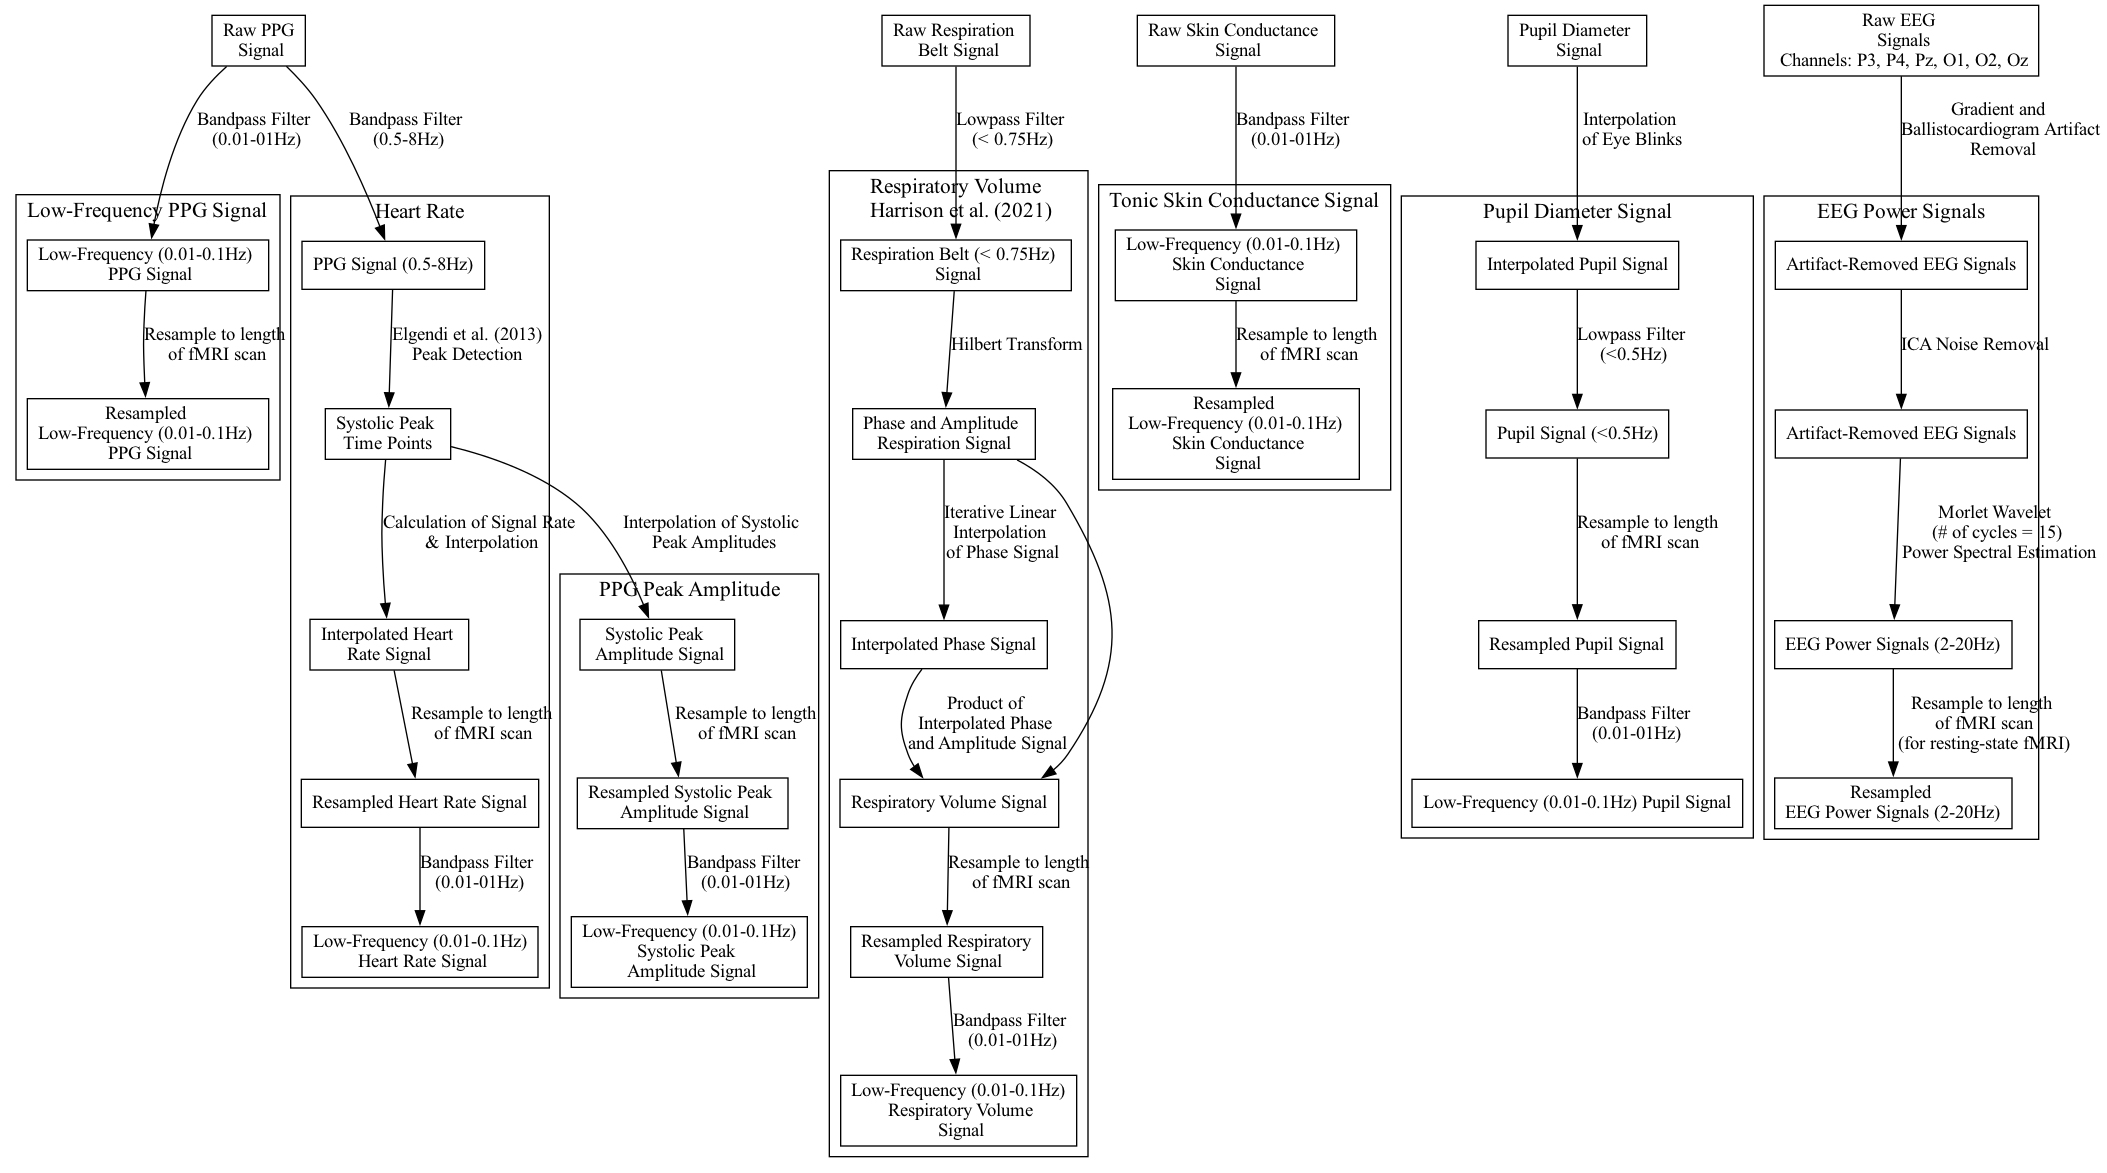

In [89]:
# The Pydot (pydot==1.4.2) package is not in the requirements.txt file, it's only needed for the following
# flowchart graphic
import pydot

from IPython.display import Image, display

def view_pydot(pdot):
    plt = Image(pdot.create_png())
    display(plt)
    
dot_graph = pydot.Dot(graph_type='digraph')

# Raw Signal Nodes
ppg_node = pydot.Node('RAW_PPG', label='Raw PPG\n Signal')
ppg_node.set_shape('box')
dot_graph.add_node(ppg_node)

resp_node = pydot.Node('RAW_RESP', label='Raw Respiration \n Belt Signal')
resp_node.set_shape('box')
dot_graph.add_node(resp_node)

gsr_node = pydot.Node('RAW_GSR', label='Raw Skin Conductance \n Signal')
gsr_node.set_shape('box')
dot_graph.add_node(gsr_node)

pupil_node = pydot.Node('RAW_PUPIL', label='Pupil Diameter \n Signal')
pupil_node.set_shape('box')
dot_graph.add_node(pupil_node)

eeg_node = pydot.Node('RAW_EEG', label='Raw EEG \n Signals\n Channels: P3, P4, Pz, O1, O2, Oz')
eeg_node.set_shape('box')
dot_graph.add_node(eeg_node)


# Put separate pipelines into clusters
ppg_low_cluster=pydot.Cluster('PPG_LOW_CLUS', label='Low-Frequency PPG Signal', 
                              shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_low_cluster)

hr_cluster=pydot.Cluster('HR', label='Heart Rate',shape='rectangle', fontsize=16)
dot_graph.add_subgraph(hr_cluster)

ppg_amp_cluster=pydot.Cluster('PPG_PEAK', label='PPG Peak Amplitude', shape='rectangle', fontsize=16)
dot_graph.add_subgraph(ppg_amp_cluster)

resp_cluster=pydot.Cluster('RESP', label='Respiratory Volume \n Harrison et al. (2021)',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(resp_cluster)

gsr_cluster=pydot.Cluster('GSR', label='Tonic Skin Conductance Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(gsr_cluster)

pupil_cluster=pydot.Cluster('PUPIL', label='Pupil Diameter Signal',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(pupil_cluster)

eeg_cluster=pydot.Cluster('EEG', label='EEG Power Signals',
                           shape='rectangle', fontsize=16)
dot_graph.add_subgraph(eeg_cluster)

# First Preprocessing Nodes
ppg_low_node = pydot.Node('PPG_LOW', label='Low-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_node)
ppg_edge_low = pydot.Edge('RAW_PPG', 'PPG_LOW', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge_low)

ppg_proc1_node = pydot.Node('PROC1_PPG', label='PPG Signal (0.5-8Hz)')
ppg_proc1_node.set_shape('box')
hr_cluster.add_node(ppg_proc1_node)
ppg_edge1 = pydot.Edge('RAW_PPG', 'PROC1_PPG', label='Bandpass Filter \n(0.5-8Hz)')
dot_graph.add_edge(ppg_edge1)

resp_proc1_node = pydot.Node('PROC1_RESP', label='Respiration Belt (< 0.75Hz) \n Signal')
resp_proc1_node.set_shape('box')
resp_cluster.add_node(resp_proc1_node)
resp_edge1 = pydot.Edge('RAW_RESP', 'PROC1_RESP', label='Lowpass Filter \n(< 0.75Hz)')
dot_graph.add_edge(resp_edge1)

gsr_proc1_node = pydot.Node('PROC1_GSR', label='Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc1_node.set_shape('box')
gsr_cluster.add_node(gsr_proc1_node)
gsr_edge1 = pydot.Edge('RAW_GSR', 'PROC1_GSR', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(gsr_edge1)

pupil_proc1_node = pydot.Node('PROC1_PUPIL', label='Interpolated Pupil Signal')
pupil_proc1_node.set_shape('box')
pupil_cluster.add_node(pupil_proc1_node)
pupil_edge1 = pydot.Edge('RAW_PUPIL', 'PROC1_PUPIL', label='Interpolation\n of Eye Blinks')
dot_graph.add_edge(pupil_edge1)

eeg_proc1_node = pydot.Node('PROC1_EEG', label='Artifact-Removed EEG Signals')
eeg_proc1_node.set_shape('box')
eeg_cluster.add_node(eeg_proc1_node)
eeg_edge1 = pydot.Edge('RAW_EEG', 'PROC1_EEG', label='Gradient and \nBallistocardiogram Artifact\n Removal')
dot_graph.add_edge(eeg_edge1)

# Second Preprocessing Nodes
ppg_proc2_node = pydot.Node('PROC2_PPG', label='Systolic Peak \nTime Points')
ppg_proc2_node.set_shape('box')
hr_cluster.add_node(ppg_proc2_node)
ppg_edge2 = pydot.Edge('PROC1_PPG', 'PROC2_PPG', label='Elgendi et al. (2013)\nPeak Detection')
dot_graph.add_edge(ppg_edge2)

ppg_low_proc1_node = pydot.Node('PROC1_PPG_LOW', label='Resampled \nLow-Frequency (0.01-0.1Hz) \n PPG Signal')
ppg_low_proc1_node.set_shape('box')
ppg_low_cluster.add_node(ppg_low_proc1_node)
ppg_edge_low2 = pydot.Edge('PPG_LOW', 'PROC1_PPG_LOW', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge_low2)

resp_proc2_node = pydot.Node('PROC2_RESP', label='Phase and Amplitude \nRespiration Signal')
resp_proc2_node.set_shape('box')
resp_cluster.add_node(resp_proc2_node)
resp_edge2 = pydot.Edge('PROC1_RESP', 'PROC2_RESP', label='Hilbert Transform')
dot_graph.add_edge(resp_edge2)

gsr_proc2_node = pydot.Node('PROC2_GSR', label='Resampled \n Low-Frequency (0.01-0.1Hz) \n Skin Conductance\n Signal')
gsr_proc2_node.set_shape('box')
gsr_cluster.add_node(gsr_proc2_node)
gsr_edge2 = pydot.Edge('PROC1_GSR', 'PROC2_GSR', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(gsr_edge2)

pupil_proc2_node = pydot.Node('PROC2_PUPIL', label='Pupil Signal (<0.5Hz)')
pupil_proc2_node.set_shape('box')
pupil_cluster.add_node(pupil_proc2_node)
pupil_edge2 = pydot.Edge('PROC1_PUPIL', 'PROC2_PUPIL', label='Lowpass Filter\n (<0.5Hz)')
dot_graph.add_edge(pupil_edge2)

eeg_proc2_node = pydot.Node('PROC2_EEG', label='Artifact-Removed EEG Signals')
eeg_proc2_node.set_shape('box')
eeg_cluster.add_node(eeg_proc2_node)
eeg_edge2 = pydot.Edge('PROC1_EEG', 'PROC2_EEG', label='ICA Noise Removal')
dot_graph.add_edge(eeg_edge2)

# Third Preprocessing Nodes
ppg_proc3_node = pydot.Node('PROC3_PPG', label='Interpolated Heart \nRate Signal')
ppg_proc3_node.set_shape('box')
hr_cluster.add_node(ppg_proc3_node)
ppg_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_PPG', label='Calculation of Signal Rate\n & Interpolation')
dot_graph.add_edge(ppg_edge3)

ppg_amp_proc3_node = pydot.Node('PROC3_AMP_PPG', label='Systolic Peak \n Amplitude Signal')
ppg_amp_proc3_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc3_node)
ppg_amp_edge3 = pydot.Edge('PROC2_PPG', 'PROC3_AMP_PPG', label='Interpolation of Systolic\n Peak Amplitudes')
dot_graph.add_edge(ppg_amp_edge3)

resp_proc3_node = pydot.Node('PROC3_RESP', label='Interpolated Phase Signal')
resp_proc3_node.set_shape('box')
resp_cluster.add_node(resp_proc3_node)
resp_edge3 = pydot.Edge('PROC2_RESP', 'PROC3_RESP', label='Iterative Linear \nInterpolation \nof Phase Signal')
dot_graph.add_edge(resp_edge3)

pupil_proc3_node = pydot.Node('PROC3_PUPIL', label='Resampled Pupil Signal')
pupil_proc3_node.set_shape('box')
pupil_cluster.add_node(pupil_proc3_node)
pupil_edge3 = pydot.Edge('PROC2_PUPIL', 'PROC3_PUPIL', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(pupil_edge3)

eeg_proc3_node = pydot.Node('PROC3_EEG', label='EEG Power Signals (2-20Hz)')
eeg_proc3_node.set_shape('box')
eeg_cluster.add_node(eeg_proc3_node)
eeg_edge3 = pydot.Edge('PROC2_EEG', 'PROC3_EEG', label='Morlet Wavelet \n(# of cycles = 15)\n Power Spectral Estimation')
dot_graph.add_edge(eeg_edge3)

# Fourth Preprocessing Nodes
ppg_proc4_node = pydot.Node('PROC4_PPG', label='Resampled Heart Rate Signal')
ppg_proc4_node.set_shape('box')
hr_cluster.add_node(ppg_proc4_node)
ppg_edge4 = pydot.Edge('PROC3_PPG', 'PROC4_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_edge4)

ppg_amp_proc4_node = pydot.Node('PROC4_AMP_PPG', label='Resampled Systolic Peak \n Amplitude Signal')
ppg_amp_proc4_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc4_node)
ppg_amp_edge4 = pydot.Edge('PROC3_AMP_PPG', 'PROC4_AMP_PPG', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(ppg_amp_edge4)

resp_proc4_node = pydot.Node('PROC4_RESP', label='Respiratory Volume Signal')
resp_proc4_node.set_shape('box')
resp_cluster.add_node(resp_proc4_node)
resp_edge4_1 = pydot.Edge('PROC3_RESP', 'PROC4_RESP', 
                        label='Product of \nInterpolated Phase \nand Amplitude Signal')
resp_edge4_2 = pydot.Edge('PROC2_RESP', 'PROC4_RESP')
dot_graph.add_edge(resp_edge4_1)
dot_graph.add_edge(resp_edge4_2)

pupil_proc4_node = pydot.Node('PROC4_PUPIL', label='Low-Frequency (0.01-0.1Hz) Pupil Signal')
pupil_proc4_node.set_shape('box')
pupil_cluster.add_node(pupil_proc4_node)
pupil_edge4 = pydot.Edge('PROC3_PUPIL', 'PROC4_PUPIL', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(pupil_edge4)

eeg_proc4_node = pydot.Node('PROC4_EEG', label='Resampled \nEEG Power Signals (2-20Hz)')
eeg_proc4_node.set_shape('box')
eeg_cluster.add_node(eeg_proc4_node)
eeg_edge4 = pydot.Edge('PROC3_EEG', 'PROC4_EEG', 
                       label='Resample to length\n of fMRI scan\n (for resting-state fMRI)')
dot_graph.add_edge(eeg_edge4)

# Fifth Preprocessing Nodes
ppg_proc5_node = pydot.Node('PROC5_PPG', label='Low-Frequency (0.01-0.1Hz)\n Heart Rate Signal')
ppg_proc5_node.set_shape('box')
hr_cluster.add_node(ppg_proc5_node)
ppg_edge5 = pydot.Edge('PROC4_PPG', 'PROC5_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_edge5)

ppg_amp_proc5_node = pydot.Node('PROC5_AMP_PPG', label='Low-Frequency (0.01-0.1Hz)\nSystolic Peak \n Amplitude Signal')
ppg_amp_proc5_node.set_shape('box')
ppg_amp_cluster.add_node(ppg_amp_proc5_node)
ppg_amp_edge5 = pydot.Edge('PROC4_AMP_PPG', 'PROC5_AMP_PPG', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(ppg_amp_edge5)

resp_proc5_node = pydot.Node('PROC5_RESP', label='Resampled Respiratory\n Volume Signal')
resp_proc5_node.set_shape('box')
resp_cluster.add_node(resp_proc5_node)
resp_edge5 = pydot.Edge('PROC4_RESP', 'PROC5_RESP', label='Resample to length\n of fMRI scan')
dot_graph.add_edge(resp_edge5)

# Sixth Preprocessing Node
resp_proc6_node = pydot.Node('PROC6_RESP', label='Low-Frequency (0.01-0.1Hz)\n Respiratory Volume\n Signal')
resp_proc6_node.set_shape('box')
resp_cluster.add_node(resp_proc6_node)
resp_edge6 = pydot.Edge('PROC5_RESP', 'PROC6_RESP', label='Bandpass Filter \n(0.01-01Hz)')
dot_graph.add_edge(resp_edge6)



view_pydot(dot_graph)

## 8.5 Multi-Set CCA Simulation

### 8.5.1 Fit MCCA

[0.85676061 0.82940959 0.14325057 0.0647584 ]
[-1.55460701 -1.55647381]


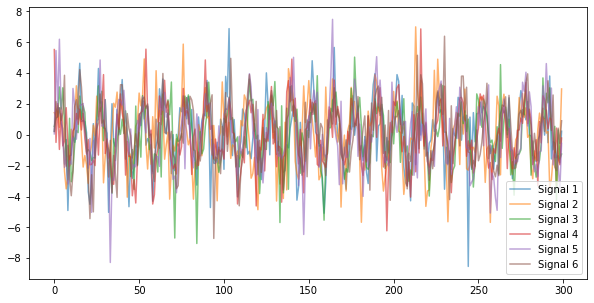

In [352]:
# Signal Parameters
n_signals = 6
amplitude = 2
noise = 1
freq = 0.08
phase_shift_range = [0, np.pi/2]
duration = 300
sampling_rate = 1

np.random.seed(1)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
spline_df=4

n_samples = int(np.rint(duration * sampling_rate))
x = np.arange(n_samples) * (1/sampling_rate)
phase_shift = np.random.uniform(phase_shift_range[0],phase_shift_range[1], n_signals)

signal_list = []
for i, p in enumerate(phase_shift):
    signal = amplitude * np.sin(2 * np.pi * freq * x + p)
    signal += np.random.laplace(0, noise, len(x))
    signal_series = pd.Series(signal, name=f'Signal_{i}')
    signal_list.append(signal_series)

fig, ax = plt.subplots(figsize=(10,5))
signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
for i, signal in enumerate(signal_list):
    ax.plot(signal, label=signal_labels[i], alpha=0.6)
ax.legend()
    
signal_basis = []
signal_trim = []
for signal in signal_list:
    basis, lag_spline = lag_basis(signal, lag_vec, spline_df)
    # Trim NaNs introduced from lag splines
    na_indx = ~(np.isnan(basis).any(axis=1))
    signal_basis.append(basis[na_indx, :])
    signal_trim.append(signal[na_indx])

# Fit MCCA
mcca = MCCA(latent_dims=4, random_state=0)
mcca.fit(signal_basis)

# Print average pair-wise correlation
print(mcca.score(signal_basis))

# Correlation matrix
corr_mat = mcca.correlations(signal_basis)

# Get canonical components
cca_pred = mcca.transform(signal_basis)

# Get phase shift between first and second CCA comp
pred_signal1 = cca_pred[2][:,0]
pred_signal2 = cca_pred[2][:,1]

f, pxy = csd(pred_signal1, pred_signal2, 1, return_onesided=True)
f_indx = np.where( (f>(freq - 0.005)) & (f< (freq + 0.005)) ) 
print(np.angle(pxy)[f_indx])

### 8.5.2 Illustrate MCCA

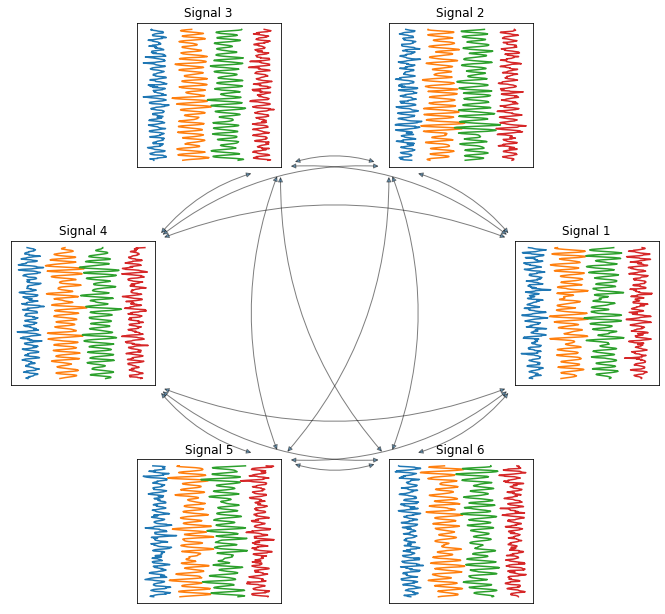

In [371]:
# Signal Parameters
N = 6
t = np.linspace(0,2*np.pi, N, endpoint=False)
r = 0.35
h = 0.9 - 2*r
w = h
X,Y = r*np.cos(t)-w/2.+ 0.5, r*np.sin(t)-h/2.+ 0.5

fig = plt.figure(figsize=(10,10))

signal_labels = [f'Signal {i+1}' for i in range(n_signals)]
axes = []
for i, (x,y) in enumerate(zip(X,Y)):
    ax = fig.add_axes([x, y, w, h])
    ax.plot(signal_basis[i][:,0]/10, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,1]/10 + 2, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,2]/10 + 4, np.arange(signal_basis[i].shape[0])[::-1])
    ax.plot(signal_basis[i][:,3]/10 + 6, np.arange(signal_basis[i].shape[0])[::-1])
    ax.set_title(signal_labels[i], fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
    axes.append(ax)

    
node_paths = {
    1: {
        2: [(0,1), (0,0), (10,30)],
        3: [(0,1), (1,0), (10,10)],
        4: [(0,1), (1,1), (10,10)],
        5: [()],
    },
    2: {
        3: [(0,0), (1,0), (15,15)],
        4: [(0,0), (1,1), (10,10)],
        6: [()]
    },
    3: {
        4: [(1,0), (1,1), (30,10)],
        5: [(1,0), (1,1), (10,10)],
        6: [(1,0), (0,1), (10,10)]
    },
    4: {
        1: [(1,0), (0,0), (10,10)],
        5: [(1,0), (1,1), (10,30)],
        6: [(1,0), (0,1), (10,10)]
    },
    5: {
        1: [(1,1), (0,0), (10,10)],
        2: [(1,1), (0,0), (10,10)],
        6: [(1,1), (0,1), (15,15)]
    },
    6: {
        1: [(0,1), (0,0), (30,10)],
        2: [(0,1), (0,0), (10,10)]
    }
}

edges = [(1,2), (1,3), (1,4), (2,3), (2,4), (3,4), (3,5), (3,6),
        (4,1), (4,5), (4,6), (5,1), (5,2), (5,6), (6,1), (6,2)]

for node_path in edges:
    i, j = node_path[0], node_path[1]
    con = ConnectionPatch(
        xyA=node_paths[i][j][0], coordsA=axes[i-1].transAxes,
        xyB=node_paths[i][j][1], coordsB=axes[j-1].transAxes, 
        shrinkA=node_paths[i][j][2][0], shrinkB=node_paths[i][j][2][1],
        connectionstyle='arc3, rad=.2', arrowstyle="<|-|>", alpha=0.5)
    axes[0].add_artist(con)



plt.show()

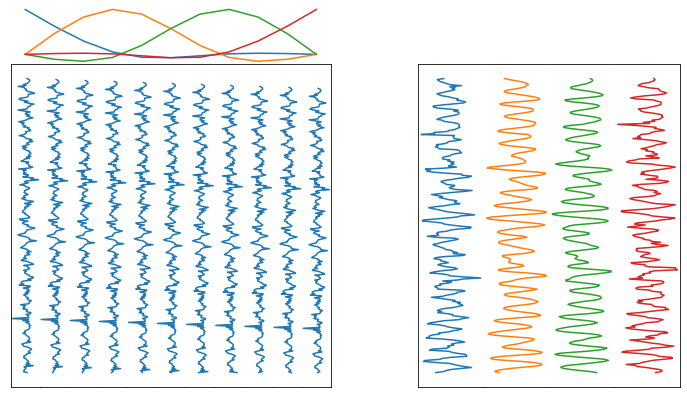

In [366]:
# Grab simulated signal
signal = signal_list[0]
signal_b = signal_basis[0]

# Start figure creation
fig = plt.figure(figsize=(12,7), constrained_layout=False)
gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.55, 0.45])

gsub1 = gspec[0].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub1_1 = gsub1[1,0].subgridspec(1,11, wspace=0)
# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
lag_nknots=4

for i, l in enumerate(lag_vec):
    if i > 0:
        ax = fig.add_subplot(gsub1_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub1_1[i])
    ax.plot(signal.shift(i), np.arange(len(signal)))
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (len(lag_vec)-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (len(lag_vec)-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

basis_lag = dmatrix("cr(x, df=4) - 1", {"x": lag_vec}, return_type='dataframe')
ax = fig.add_subplot(gsub1[0])
for i in range(basis_lag.shape[1]):
    ax.plot(basis_lag.iloc[:,i])
ax.axis('off')

gsub2 = gspec[1].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])

gsub2_1 = gsub2[1].subgridspec(1, signal_b.shape[1], wspace=0)
cmap = plt.get_cmap('tab10')
color_vec = [cmap(i) for i in range(signal_b.shape[1])]
for i in range(signal_b.shape[1]):
    if i > 0:
        ax = fig.add_subplot(gsub2_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub2_1[i])
    ax.plot(signal_b[:,i], np.arange(len(signal_b)), color=color_vec[i])
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (signal_b.shape[1]-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (signal_b.shape[1]-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

## 8.6 Distributed Lag Non-Linear Model Illustration

### 8.6.1 Illustrate Model Creation

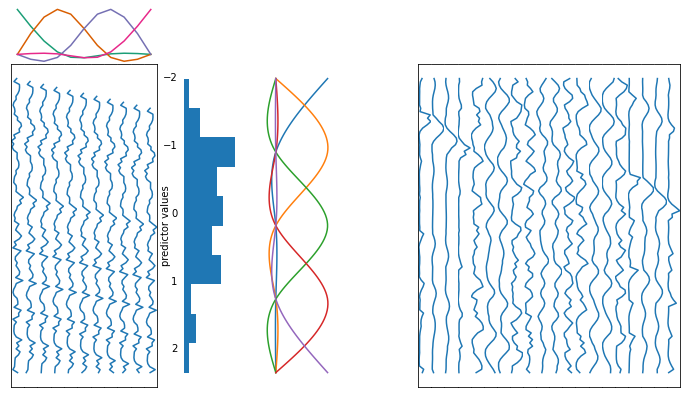

In [142]:
# Signal Parameters
amplitude = 2
noise = 1
freq = 0.08
phase_shift = np.pi/3
duration = 600
sampling_rate = 1

np.random.seed(2)

n_samples = int(np.rint(duration * sampling_rate))
x = np.arange(n_samples) * (1/sampling_rate)

signal_x = amplitude * np.sin(2 * np.pi * freq * x)
signal_x += np.random.laplace(0, noise, len(x))
signal_x= pd.Series(zscore(signal_x), name=f'Signal_X')

signal_y = amplitude * np.sin(2 * np.pi * freq * x - phase_shift)
signal_y += np.random.laplace(0, noise, len(x))
signal_y = pd.Series(zscore(signal_y), name=f'Signal_Y')

# Sample 100 time points for illustration
signal_sample = pd.Series(signal_x[:100])

# Start figure creation
fig = plt.figure(figsize=(12,7), constrained_layout=False)
gspec = fig.add_gridspec(1,2, wspace=0.3, width_ratios=[0.55, 0.45])

var_c = plt.get_cmap('tab10')
lag_c = plt.get_cmap('Dark2')

gsub1 = gspec[0].subgridspec(2,3, height_ratios=[0.15,0.85], hspace=0, 
                             width_ratios=[0.55, 0.2, 0.25], wspace=0.3)

gsub1_1 = gsub1[1,0].subgridspec(1,11, wspace=0)

# Lag Basis Spline Parameters
lag_vec = np.arange(10+1)
lag_nknots=4

for i, l in enumerate(lag_vec):
    if i > 0:
        ax = fig.add_subplot(gsub1_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub1_1[i])
    ax.plot(signal_sample.shift(i), np.arange(100))
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (len(lag_vec)-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (len(lag_vec)-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

basis_lag = dmatrix("cr(x, df=4) - 1", {"x": lag_vec}, return_type='dataframe')
ax = fig.add_subplot(gsub1[0,0])
for i in range(basis_lag.shape[1]):
    ax.plot(basis_lag.iloc[:,i], color=lag_c(i))
ax.axis('off')

ax = fig.add_subplot(gsub1[1,1])
ax.hist(signal_sample, bins=10, orientation='horizontal')
ax.set_ylabel('predictor values', labelpad=-9)
ax.spines.right.set_visible(False)
ax.spines.left.set_visible(False)
ax.spines.top.set_visible(False)
ax.spines.bottom.set_visible(False)
ax.tick_params(top=False,
               bottom=False,
               left=False,
               right=False,
               labelleft=True,
               labelbottom=True)
ax.set_xticks([])
ax.invert_yaxis()

# Predictor Basis Spline Parameters
var_x = np.linspace(signal_sample.min(),signal_sample.max(),100)
basis_var = dmatrix("cr(x, df=5) - 1", {"x": var_x}, 
                    return_type='dataframe')
ax = fig.add_subplot(gsub1[1,2])

for i in range(basis_var.shape[1]):
    ax.plot(basis_var.iloc[:,i], np.arange(len(basis_var))[::-1], color=var_c(i))


ax.axis('off')

# Display full cross-basis
basis_var_full = dmatrix("cr(x, df=5) - 1", {"x": signal_sample}, return_type='dataframe')
# Intialize crossbasis matrix
crossbasis = np.zeros((len(signal_sample), basis_var_full.shape[1]*basis_lag.shape[1]))
# Loop through predictor and lag bases and multiply column pairs
indx = 0
for v in np.arange(basis_var_full.shape[1]):
    lag_mat = pd.concat([basis_var_full.iloc[:,v].shift(i) for i in lag_vec], axis=1)
    for l in np.arange(basis_lag.shape[1]):
        crossbasis[:, indx] = np.dot(lag_mat.values, basis_lag.iloc[:,l].values)
        indx+=1

gsub2 = gspec[1].subgridspec(2,1, hspace=0, height_ratios=[0.15,0.85])
gsub2_1 = gsub2[1].subgridspec(1, crossbasis.shape[1], wspace=0)

for i in range(crossbasis.shape[1]):
    if i > 0:
        ax = fig.add_subplot(gsub2_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub2_1[i])
    ax.plot(crossbasis[:,i], np.arange(100)[::-1])
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (crossbasis.shape[1]-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (crossbasis.shape[1]-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()


# ax.xaxis.tick_top()


### 8.6.2 Illustrate Model Evaluation

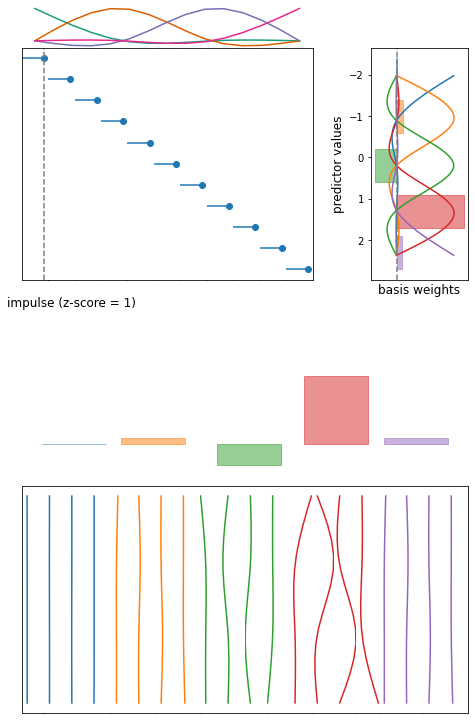

In [198]:
# Select # equally spaced values of lags
lag_max = 15

# Select z-score unit of predictor for evaluation
var_pred = np.repeat(1, lag_max)

# Create lag sequence array (include lag of 0!)
seq_lag = np.linspace(0, 10, lag_max)
# Create basis from model evaluation using previously defined design matrix (for model fit)
basis_var_pred = dmatrix(basis_var_full.design_info, {'x': var_pred}, return_type='dataframe')
basis_lag_pred = dmatrix(basis_lag.design_info, {'x': seq_lag}, return_type='dataframe')

v_len = basis_var_pred.shape[1]
l_len = basis_lag_pred.shape[1]
# Row-wise kronecker product between predicted bases to generate prediction matrix
xpred_list = [basis_var_pred.iloc[:,v]*basis_lag_pred.iloc[:,l] 
              for v in range(v_len) for l in range(l_len)]
xpred_indx = np.repeat(np.arange(5), 4)
xpred_df = pd.DataFrame(xpred_list).T

# Plot model evaluation illustration
fig = plt.figure(figsize=(8,13), constrained_layout=False)
gspec = fig.add_gridspec(2,1, height_ratios=[0.4, 0.5], hspace=0.3)
var_c = plt.get_cmap('tab10')
lag_c = plt.get_cmap('Dark2')

gsub1 = gspec[0].subgridspec(2,2, height_ratios=[0.15,0.85], hspace=0, 
                             width_ratios=[0.75, 0.25], wspace=0.3)


ax = fig.add_subplot(gsub1[0,0])
for i in range(basis_lag_pred.shape[1]):
    ax.plot(np.arange(len(basis_lag_pred)), basis_lag_pred.iloc[:,i], color=lag_c(i))
ax.axis('off')

gsub1_1 = gsub1[1,0].subgridspec(1,11, wspace=0)

# delta function plot
for i in lag_vec:
    if i > 0:
        ax = fig.add_subplot(gsub1_1[i], sharey=ax)
    else:
        ax = fig.add_subplot(gsub1_1[i])
    delta = np.full((11,), np.NaN)
    delta[i]=1
    ax.stem(np.arange(11), delta, orientation='horizontal', basefmt=" ")
    ax.set_xticks([])
    ax.set_xlim([0, 1.2])
    if i == 0:
        ax.set_yticks([1])
        ax.set_xticks([])
        ax.axvline(1,0,1, linestyle='--', color='gray')
        ax.text(0.1,0.56, 'impulse (z-score = 1)', fontsize=12,
                transform=plt.gcf().transFigure)
    else:
        ax.set_xticks([])
        ax.set_yticks([])
    
    if (i > 0) & (i < (10)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == 10:
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

# Delta function in predictor basis
ax = fig.add_subplot(gsub1[1,1])
for i in range(basis_var.shape[1]):
    ax.plot(basis_var.iloc[:,i], var_x, color=var_c(i))
weight_x = [-2, -1, 0.2, 1.3, 2.3]
barlist = ax.barh(weight_x, basis_var_pred.iloc[0,:], alpha=0.5)
ax.axvline(0, 0, 1, linestyle='--', color='gray')
ax.set_xlabel('basis weights', fontsize=12)
ax.set_ylabel('predictor values', fontsize=12)
for i, bar in enumerate(barlist):
    bar.set_color(cmap(i))
plt.gca().invert_yaxis()
ax.set_xticks([])

# Plot prediction vectors across lags
g_sub2 = gspec[1].subgridspec(2, 1, hspace=0.1, height_ratios=[0.3,0.7])


ax = fig.add_subplot(g_sub2[0])
barlist = ax.bar(weight_x, basis_var_pred.iloc[0,:], alpha=0.5)
ax.axhline(1, 1, 1, linestyle='--', color='gray')
ax.axis('off')
for i, bar in enumerate(barlist):
    bar.set_color(var_c(i))

g_sub2_2 = g_sub2[1].subgridspec(1, xpred_df.shape[1], wspace=0)
for i in range(xpred_df.shape[1]):
    if i > 0:
        ax = fig.add_subplot(g_sub2_2[i], sharey=ax)
    else:
        ax = fig.add_subplot(g_sub2_2[i])
    ax.plot(xpred_df.iloc[:,i], np.arange(lag_max)[::-1], color=var_c(xpred_indx[i]))
    ax.set_xlim([-0.4, 1.2])
    if i > 0:
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        ax.set_xticks([])
    
    if (i > 0) & (i < (xpred_df.shape[1]-1)):
        ax.spines.right.set_visible(False)
        ax.spines.left.set_visible(False)
    elif i == (xpred_df.shape[1]-1):
        ax.spines.left.set_visible(False)
    plt.gca().invert_yaxis()

plt.show()


# 10. Misc

In [12]:
from utils.load_write import convert_2d
recon_promax = []
for i in range(2):
    nifti = nb.load(f'results/cpca/hcp_cpca_recon_n{i}_promax.nii', keep_file_open = True)
    mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz').get_fdata()
    nifti_data = nifti.get_fdata()
    nifti.uncache()
    nifti_data = convert_2d(mask, nifti_data)
    if i == 0:
        nifti_data*=-1
    recon_promax.append(nifti_data)
recon_promax = np.stack(recon_promax, axis=2)

In [135]:
weight_vec = [0.6,0.4]
for i in range(2):
    if i == 1:
        recon_promax[:,:,i] = np.roll(recon_promax[:,:,i], 6, 0)
    recon_promax[:,:,i] *= weight_vec[i]
recon_sum = recon_promax.sum(axis=2)

In [136]:
mask = nb.load('masks/MNI152_T1_3mm_brain_mask_dilated.nii.gz')
mask_bin = mask.get_fdata() > 0
nifti_4d = np.zeros(mask.shape + (recon_sum.shape[0],), dtype=recon_sum.dtype)
nifti_4d[mask_bin, :] = recon_sum.T
nifti_out = nb.Nifti2Image(nifti_4d, mask.affine)
nb.save(nifti_out, 'recon_sum.nii')

In [137]:
cpca_ts = pickle.load(open('results/cpca/chang_pca_group_c_results.pkl', 'rb'))['pc_scores']
cpca_promax_ts = pickle.load(open('results/cpca/chang_pca_group_promax_c_results.pkl', 'rb'))['pc_scores']

In [138]:
cpca_ts_real = np.real(cpca_ts)
cpca_promax_ts_real = np.real(cpca_promax_ts)
cpca_promax_ts_real[:,0] *= -1

In [82]:
subj = 25
scan=12
df_subj = load_subj_chang_bh(subj, scan, pc_subj_chang[f'{subj}_{scan}'], pc_p_subj_chang[f'{subj}_{scan}'], fs_chang)
breath_onset_vec = np.zeros((df_subj.shape[0], 1))
breath_onset_vec[breath_onsets_tr] = 1
df_subj['breath_onset'] = breath_onset_vec

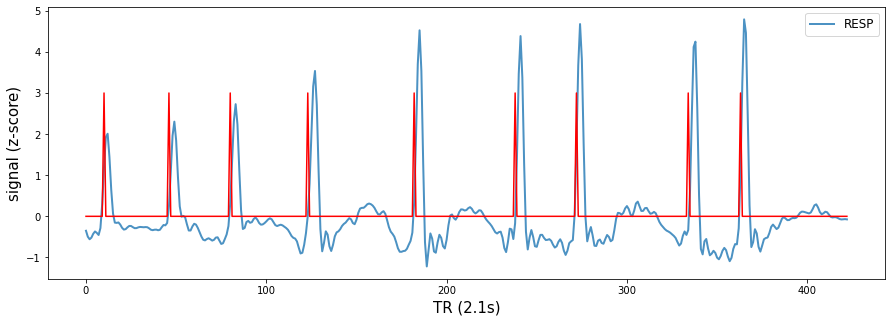

In [83]:
fig, ax = plt.subplots(figsize=(15,5))
# ax.plot(df_subj['pc1'], label='PC1', linewidth=2, alpha=0.8)
ax.plot(df_subj['RESP_AMP_HILBERT'] ,label='RESP', linewidth=2, alpha=0.8)
ax.plot(df_subj['breath_onset']*3, color='r')
ax.set_xlabel('TR (2.1s)', fontsize=15)
ax.set_ylabel('signal (z-score)', fontsize=15)
ax.legend(fontsize=12)

In [290]:
breath_onsets_vec = np.zeros((df_subj.shape[0], 1))
breath_onsets_vec[breath_onsets_tr] = 1

def shifted_onsets(breath_onsets_vec):
    rand_shift = np.random.randint(0, len(breath_onsets_vec))
    breath_onsets_vec_rand = np.roll(breath_onsets_vec, rand_shift)
    breath_onsets_rand_tr = np.where(breath_onsets_vec_rand==1)[0]
    return breath_onsets_rand_tr

signal_ts = df_subj['Alpha'].values[np.newaxis, :]
signal_blocks = np.squeeze(signal_ts[:,bh_event_blocks])
signal_mean = signal_blocks.mean(axis=0)

perm_avg = []
for i in range(500):
    rand_onsets = shifted_onsets(breath_onset_vec)
    bh_event_blocks_rand = construct_deep_breath_blocks(rand_onsets, 2.1)
    bh_event_blocks_rand = [tuple(b) for b in bh_event_blocks_rand]
    signal_blocks_rand = np.squeeze(signal_ts[:,bh_event_blocks_rand])
    signal_mean_rand = signal_blocks_rand.mean(axis=0)
    perm_avg.append(np.abs(signal_mean_rand))
    

In [291]:
perm_95 = np.percentile(perm_avg, 95, axis=0)
np.abs(signal_mean) > perm_95

array([False,  True,  True,  True, False, False,  True,  True, False,
       False, False, False, False, False, False])

In [37]:
kmeans = MiniBatchKMeans(n_clusters=3)
kmeans.fit(nifti_data.T)

MiniBatchKMeans(n_clusters=3)

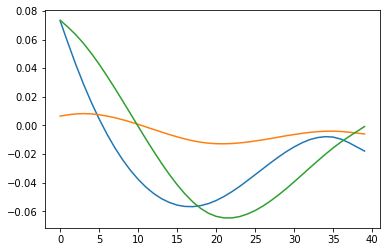

In [38]:
plt.plot(kmeans.cluster_centers_.T)

In [39]:
data_write = kmeans.labels_[np.newaxis, :]+1
nifti_4d = np.zeros(mask.shape + (data_write.shape[0],), 
                    dtype=data_write.dtype)
nifti_4d[mask, :] = data_write.T
nifti_out = nb.Nifti2Image(nifti_4d, mask_full.affine)
nb.save(nifti_out, 'hcp_fix_test3.nii')

In [18]:
from glob import glob
import json
import os
import neurokit2 as nk
from scipy.signal import welch

In [38]:
fps = glob('data/dataset_nki/physio/raw/*.tsv.gz')
fps.sort()

In [21]:
for fp in fps:
    physio_df = pd.read_csv(fp, compression='gzip', sep='\t', header=None, usecols=[0,1,2,3])
    subj_base = fp.rsplit('.tsv')[0]
    physio_json = json.load(open(f'{subj_base}.json'))
    physio_df.columns = physio_json['Columns']
    sf_physio = physio_json['SamplingFrequency']
    
    fig, ax = plt.subplots(figsize=(15,10))
    physio_df['gsr'].plot(ax=ax, alpha=0.5)
    plt.savefig(f'{os.path.splitext(os.path.splitext(fp)[0])[0]}_gsr.png')
    plt.close(fig)
    
    fig, ax = plt.subplots(figsize=(10,5))
    physio_secs = len(physio_df['gsr'])/sf_physio
    physio_resamp_n = int(physio_secs * 5)
    gsr_resamp = nk.signal_resample(physio_df['gsr'], desired_length=physio_resamp_n, method='FFT')
    f, pxx = welch(gsr_resamp, 5, nperseg=1000, noverlap=500)
    ax.semilogy(f, pxx)
    f_low = f[f <= 0.1]
    ax.fill_between(f_low, 0, max(pxx), facecolor='red', alpha=0.5)
    plt.savefig(f'{os.path.splitext(os.path.splitext(fp)[0])[0]}_gsr_psd.png')
    plt.close(fig)


In [64]:
gsr_list = []
resp_list = []
for fp in fps:
    physio_df = pd.read_csv(fps[indx], compression='gzip', sep='\t', header=None, usecols=[0,1,2,3])
    # print(fps[indx])
    subj_base = fp.rsplit('.tsv')[0]
    physio_json = json.load(open(f'{subj_base}.json'))
    physio_df.columns = physio_json['Columns']
    sf_physio = physio_json['SamplingFrequency']
    physio_secs = len(physio_df['gsr'])/sf_physio
    physio_resamp_n = int(physio_secs * 5)
    gsr_resamp = nk.signal_resample(physio_df['gsr'], desired_length=physio_resamp_n, method='FFT')
    resp_resamp = nk.signal_resample(physio_df['respiratory'], desired_length=physio_resamp_n, method='FFT')
    gsr_filt = butterworth_filter(gsr_resamp, 0.01, 0.1, 5, 'bandpass')
    gsr_list.append(zscore(gsr_filt))
    resp_list.append(zscore(resp_resamp))



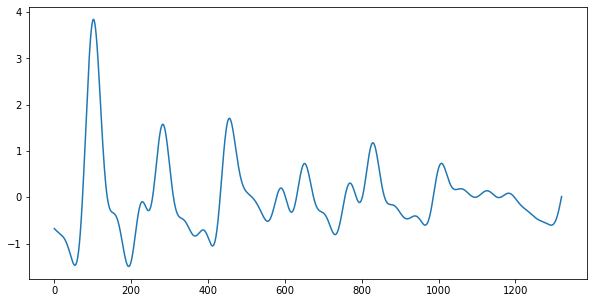

In [72]:
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(np.mean(gsr_list, axis=0))
# plt.plot(np.mean(resp_list, axis=0))

In [52]:
# def load_hcp_task_event_file(ev_dir, task):
    if task == 'hcp_rel':
        rel = np.loadtxt(f'{ev_dir}/relation.txt', unpack=True)
        match = np.loadtxt(f'{ev_dir}/match.txt', unpack=True)
        all_trials = np.concatenate([rel, match], axis=1)
    elif task == 'hcp_wm':
        bk_str = ['0bk', '2bk']
        stimuli_str = ['body', 'faces', 'tools', 'places']
        all_trials = [np.loadtxt(f'{ev_dir}/{bk}_{stimuli}.txt', unpack=True) 
                      for bk in bk_str for stimuli in stimuli_str]
        all_trials = np.vstack(all_trials).T
    all_trials = {['onset','duration'][i]: all_trials[i] for i in range(2)}
    trials_df = pd.DataFrame(all_trials).sort_values(by='onset')
    return trials_df


<AxesSubplot:xlabel='time'>

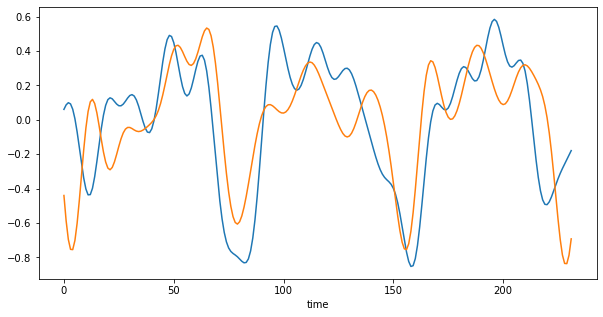

In [12]:
subject_list_task = pd.read_csv('data/dataset_hcp_task/subject_list_hcp_relational.csv')

physio_group = []
for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
    df = pd.read_csv(f'data/dataset_hcp_task/physio_rel/proc1_physio/{subj}_physio.csv')
    df = df.apply(lambda x: zscore(butterworth_filter(x, 0.01, 0.1, fs=fs_hcp, filter_type='bandpass')), axis=0)
    df['subj'] = subj
    df['time'] = df.index
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)

event_blocks = []
for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
        event_dir = f'data/dataset_hcp_task/events_rel/{subj}_{scan}_EV'
        event_df = load_hcp_task_event_file(event_dir, 'hcp_rel')
        event_blocks.append(onsets_to_block(event_df, 232, 0.72))

fig, ax = plt.subplots(figsize=(10,5))
# plt.plot(event_blocks[0])
physio_concat.groupby('time')['RESP_RATE_NK'].mean().plot(ax=ax, label='rate')
physio_concat.groupby('time')['RESP_RVT_NK'].mean().plot(ax=ax, label='volume')

In [35]:
task_fp = 'wm'
task = 'wm'
task_len = 405

subject_list_task = pd.read_csv(f'data/dataset_hcp_task/subject_list_hcp_{task_fp}.csv')
pca_output = pickle.load(open(f'results/pca/hcp_{task}_pca_group_results.pkl', 'rb'))
pca_output_p = pickle.load(open(f'results/pca/hcp_{task}_pca_group_promax_results.pkl', 'rb'))
pc_ts = pca_output['pc_scores']
pc_ts_p = pca_output_p['pc_scores']

n_t = 0
pc_subj_hcp = {}
pc_p_subj_hcp = {}
for i, subj in enumerate(subject_list_task.subject):
    # Extract subject PC time series
    pc_subj_hcp[f'{subj}'] = pc_ts[n_t:(n_t+task_len),:]
    # Extract subject PC-Promax time series
    pc_p_subj_hcp[f'{subj}'] = pc_ts_p[n_t:(n_t+task_len),:]
    n_t += task_len

In [36]:
physio_group = []
hrf = get_hrf(30, 0.72, 'canonical')

for subj, scan in zip(subject_list_task.subject, subject_list_task.lr):
    df = pd.read_csv(f'data/dataset_hcp_task/physio_{task}/proc1_physio/{subj}_physio.csv')
    df = df.apply(lambda x: zscore(butterworth_filter(x, 0.01, 0.1, fs=fs_hcp, filter_type='bandpass')), axis=0)
    df['subj'] = subj
    df['time'] = df.index
    df['pc1'] = pc_subj_hcp[f'{subj}'][:,0]
    df['pc1_p'] = pc_p_subj_hcp[f'{subj}'][:,0]
    df['pc2_p'] = pc_p_subj_hcp[f'{subj}'][:,1]
    df['pc3_p'] = pc_p_subj_hcp[f'{subj}'][:,2]
    event_dir = f'data/dataset_hcp_task/events_{task}/{subj}_{scan}_EV'
    event_df = load_hcp_task_event_file(event_dir, f'hcp_{task}')
    event_blocks = onsets_to_block(event_df, task_len, 0.72)
    block_ts = np.zeros(df.shape[0])
    for block_i in event_blocks:
        block_ts[block_i] = 1
    df['task_design'] = block_ts
    conv_event_blocks = convolve_hrf(hrf, block_ts)
    df['task_design_hrf'] = conv_event_blocks
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)

In [41]:
%matplotlib qt
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(block_ts)
ax.plot(conv_event_blocks / conv_event_blocks.max())

physio_concat.groupby('time')['RESP_RVT_NK'].mean().plot(ax = ax)
# physio_concat.groupby('time')['PPG_LOW_NK'].mean().plot(ax = ax)

<AxesSubplot:xlabel='time'>

In [73]:
task_wm_res = pickle.load(open('hcp_rel_task_reg_results.pkl', 'rb'))

In [74]:
np.quantile(task_wm_res[1]['physio'], 0.6)

2.52679040568366

In [89]:
subject_list_hcp_master = pd.read_csv('data/dataset_hcp/subject_list_hcp_master.csv')

for subj, scan in zip(subject_list_hcp_master.subject, subject_list_hcp_master.lr):
    for task in ['1_rest', '_relational', '_wm']:
        try:
            physio_signals = np.loadtxt(f'data/dataset_hcp/test_physio/{subj}_{scan}{task}_physio.txt')
        except:
            continue
        physio_signals_df = pd.DataFrame({ 
         'resp': physio_signals[:,1],
         'ppg': physio_signals[:,2]
         })
        # Downsample to 100Hz (400Hz is unnecessary)
        physio_secs = physio_signals_df.shape[0]/400
        physio_resamp_n = int(physio_secs * 100)
        physio_signals_resamp = physio_signals_df.apply(
            nk.signal_resample, desired_length=physio_resamp_n, method='FFT', axis=0
        )
        fig, ax = plt.subplots(figsize=(10,8))
        ax.plot(physio_signals_resamp['resp'], label='resp')
        ax.plot(physio_signals_resamp['ppg'], alpha=0.5, label='ppg')
        ax.legend()
        plt.savefig(f'data/dataset_hcp/test_physio/{subj}_{scan}{task}_physio.png')
        plt.close()

In [275]:
from utils.load_write import convert_2d
recon_promax = []
nifti = nb.load(f'monash_pet_pca_group.nii')
mask = nb.load('masks/MNI152_T1_3mm_gray_mask.nii.gz').get_fdata()
nifti_data = nifti.get_fdata()*-1
nifti.uncache()
nifti_data = convert_2d(mask, nifti_data)

In [276]:
yeo = nb.load(f'data/templates/Yeo2011_7Networks_MNI152_FreeSurferConformed1mm_LiberalMask.nii.gz')
yeo_data = yeo.get_fdata()
yeo.uncache()
yeo_cluster = convert_2d(mask, yeo_data)

In [277]:
mean_clus = []
std_clus = []
for i in range(1,8):
    clus_i = np.where(yeo_cluster==i)[0]
    mean_clus.append(nifti_data[0,clus_i].mean())
    std_clus.append(nifti_data[0,clus_i].std())

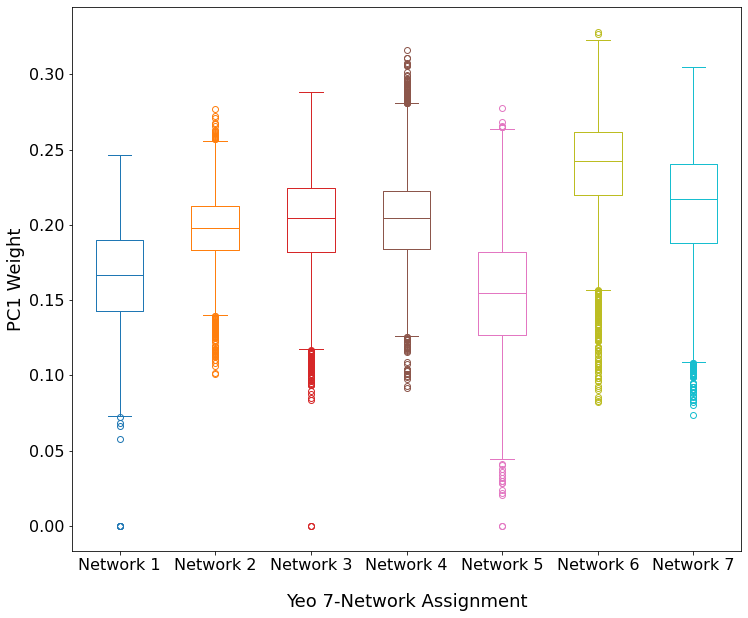

In [300]:
fig, ax = plt.subplots(figsize=(12,10))

tab_cmap = plt.cm.get_cmap('tab10')
np.random.seed(123)
net_labels = [f'Network {i+1}' for i in range(7)]

w = 0.8    # bar width
color_select = [0,1,3,5,6,8,9]
tab_cmap_select = [tab_cmap(c) for c in color_select]
x = np.arange(7)
for i in range(7):
    c = tab_cmap_select[i]
    ax.boxplot(bx_test[i], positions=[x[i]+1],
               widths=0.5,
               boxprops=dict(color=c),
               capprops=dict(color=c),
               whiskerprops=dict(color=c),
               flierprops=dict(color=c, markeredgecolor=c),
               medianprops=dict(color=c))
ax.yaxis.set_tick_params(labelsize=16)
ax.set_ylabel('PC1 Weight', fontsize=18)
ax.set_xlabel('Yeo 7-Network Assignment', fontsize=18, labelpad=20)
ax.set_xticks(x+1, net_labels, fontsize=16)


In [25]:
hcp_rel = pickle.load(open('hcp_rel_task_glm_results.pkl', 'rb'))

In [4]:
subject_list_hcp = pd.read_csv(f'data/dataset_chang/subject_list_chang.csv')
physio_group = []

# Loop through subjects and run regression
for i in range(subject_list_chang.shape[0]):
    # Load Subject
    subj, scan = subject_list_chang.iloc[i, 0], subject_list_chang.iloc[i, 1]
    sleep = subject_list_chang.iloc[i, 2]
    df = load_subj_chang(subj, scan, pc_subj_chang[f'{subj}_{scan}'], 
                         pc_p_subj_chang[f'{subj}_{scan}'], fs_chang, bp_filter=True)
    df['subject'] = subj
    physio_group.append(df)

physio_concat = pd.concat(physio_group, axis=0, ignore_index=True)
physio_concat['vigilance_at_diff'] = np.diff(physio_concat['vigilance_at'], prepend=0)

In [14]:
physio_concat[['RESP_RVT_NK', 'RESP_AMP_HILBERT']].apply(zscore, axis=0).plot()

<AxesSubplot:>

In [2]:
subject_list_yale = pd.read_csv('data/dataset_yale/subject_list_yale.csv')

In [18]:
for subj, scan in zip(subject_list_yale.subject, subject_list_yale.scan):
    pupil_dil = pd.read_csv(f'data/dataset_yale/physio/raw/{subj}_task-rest_run-0{scan}_et.tsv')
    # fig, ax = plt.subplots(figsize=(10,5))
    # ax.plot(pupil_dil)
    # plt.savefig(f'data/dataset_yale/physio/raw/{subj}_task-rest_run-0{scan}_et.png')
    # plt.close(fig)

In [26]:
pupil_dil = pd.read_csv(f'data/dataset_yale/physio/raw/sub-pa1387_task-rest_run-02_et.tsv', 
                        delimiter='\t', header=None)

pupil_dil

,0
0,5216.768865
1,5086.519904
2,4819.820447
3,4844.306486
4,4615.361181
...,...
395,2058.788198
396,1946.610686
397,1598.796480
398,687.705640


In [372]:
sf_physio_resamp=100
physio_raw = loadmat('data/dataset_chang/physio/raw/sub_0010-mr_0009-ecr_echo1_physOUT.mat', squeeze_me=True)
sf_physio = 1/physio_raw['OUT_p']['dt_phys'].item()
# Pull physio data into dict
ppg = physio_raw['OUT_p']['card_dat'].item()
resp = physio_raw['OUT_p']['resp'].item()['wave'].item()
physio = {'ppg': ppg, 'resp': resp}
# Downsample to 100Hz (2000Hz is unnecessary)
physio_secs = len(physio['resp'])/sf_physio
physio_resamp_n = int(physio_secs * sf_physio_resamp)
physio = {l: nk.signal_resample(physio[l], desired_length=physio_resamp_n, method='FFT') 
          for l in physio.keys()}
# Trim off first 14.7s to align w/ functional (first 7 TRs were trimmed from functional)
trim_n = int(sf_physio_resamp*14.7)
physio_trim = {l: physio[l][trim_n:] for l in physio.keys()}

In [401]:
resp_df, _ = nk.rsp_process(physio['resp'], sf_physio_resamp)
resp_df['RSP_Clean_scaled'] = resp_df['RSP_Clean']*10

In [411]:
%matplotlib qt
resp_df[['RSP_Clean_scaled', 'RSP_Phase', 'RSP_Peaks', 'RSP_Troughs']].plot(legend=False)

<AxesSubplot:>

In [417]:
resp_resamp = nk.signal_resample(resp_df['RSP_Clean'], sampling_rate=100, desired_sampling_rate=1.38, method='FFT') 

In [418]:

plt.plot(resp_resamp)